# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 10.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [3]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import zipfile
import datetime as dt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

np.random.seed(911)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/nyc-taxi-trip-duration/train.zip',compression='zip')
df.sample(5)

id  vendor_id      pickup_datetime     dropoff_datetime  \
863533   id0419249          1  2016-01-16 00:01:23  2016-01-16 00:28:12   
1253427  id3719423          1  2016-05-01 16:12:50  2016-05-01 16:35:07   
284588   id1255103          2  2016-04-26 17:49:04  2016-04-26 18:04:39   
753231   id2122753          2  2016-02-21 10:46:02  2016-02-21 11:07:34   
281749   id1013783          1  2016-05-05 10:20:03  2016-05-05 10:44:22   

         passenger_count  pickup_longitude  pickup_latitude  \
863533                 2        -73.992737        40.724365   
1253427                1        -73.989876        40.746796   
284588                 1        -73.987427        40.768581   
753231                 1        -73.969933        40.797970   
281749                 2        -73.971931        40.746567   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
863533          -73.977272         40.792065                  N           1609  
1253427         -73.969498         40.800369                  N           1337  
284588          -73.968994         40.755867                  N            935  
753231          -73.983902         40.762470                  N           1292  
281749          -73.943802         40.726883                  N           1459

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df = df.drop(columns = ['dropoff_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

4

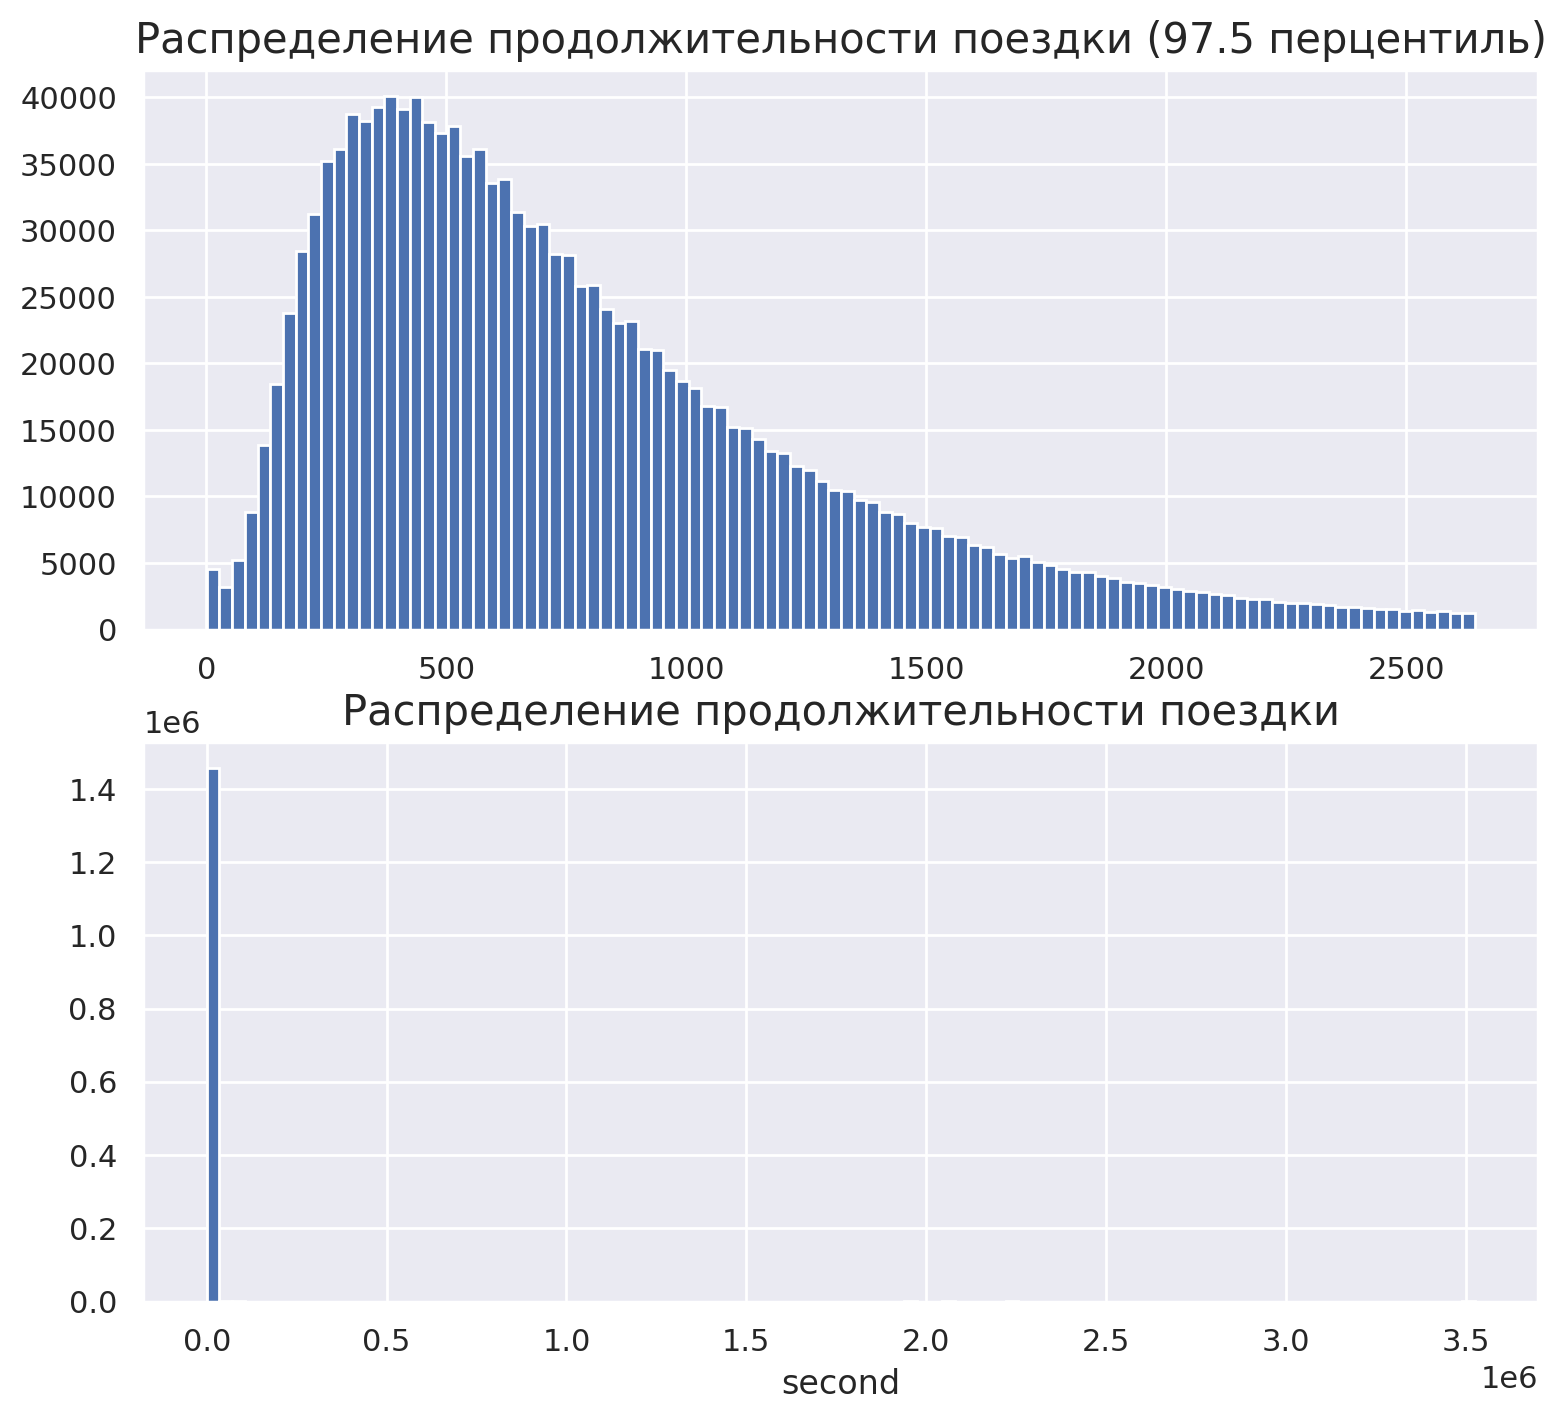

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(9, 8))
axes[0].set_title('Распределение продолжительности поездки (97.5 перцентиль)', fontsize=15) # Из-за больших выбросов
axes[1].set_title('Распределение продолжительности поездки', fontsize=15)

axes[1].hist(df['trip_duration'], bins=100)
axes[0].hist(df['trip_duration'][df['trip_duration'] <= np.percentile(df['trip_duration'], 97.5)], bins=100)
axes[1].set_xlabel('second')


gc.collect()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Смотря на оба графика можно сказать следующее:

1. У неё существуют нереалистичные выбросы. Так некоторые данные дают многодневные поездки в рамках города.  
2. Распределение напоминает распределения Фишера/Хи-квадрат.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Предполагаю, что авторам было важнее угадать порядок времени поездки, чем приблизить наиболее точно.

Для точного предсказывания примерного времени поездки в конкретный момент необходимо знать и уметь интерпретировать как признаки такие сложные концепции, как пробки на дорогах, инфраструктура города, погодные условия. Более того, эти параметры при предсказании можно зафиксировать только в момент перед отправлением такси. Влияние этих обстоятельств существенны.

Тем самым при предсказании разность предсказанного и фактического значения будет, как правило, существенно отличаться. Что будет отрицательно влиять на качество обучения при использовании RMSE. RMSLE помогает уменьшить диапазон значений, тем самым избежать переобучения.


На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} \xrightarrow{\hat{y_i} = log(y_i + 1)} \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \log{(a(x_i) + 1)}\big)^2} \xrightarrow{a(x_i) = \exp(\hat{a}(x_i)) - 1} \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \log{(\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2} =  \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \log{(\exp(\hat{a}(x_i)))}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \hat{a}(x_i)\big)^2} = MSE(X, \hat{y}, \hat{a})$$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [8]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])
df = df.drop(columns = ['trip_duration'])

Text(0, 0.5, 'Количество')

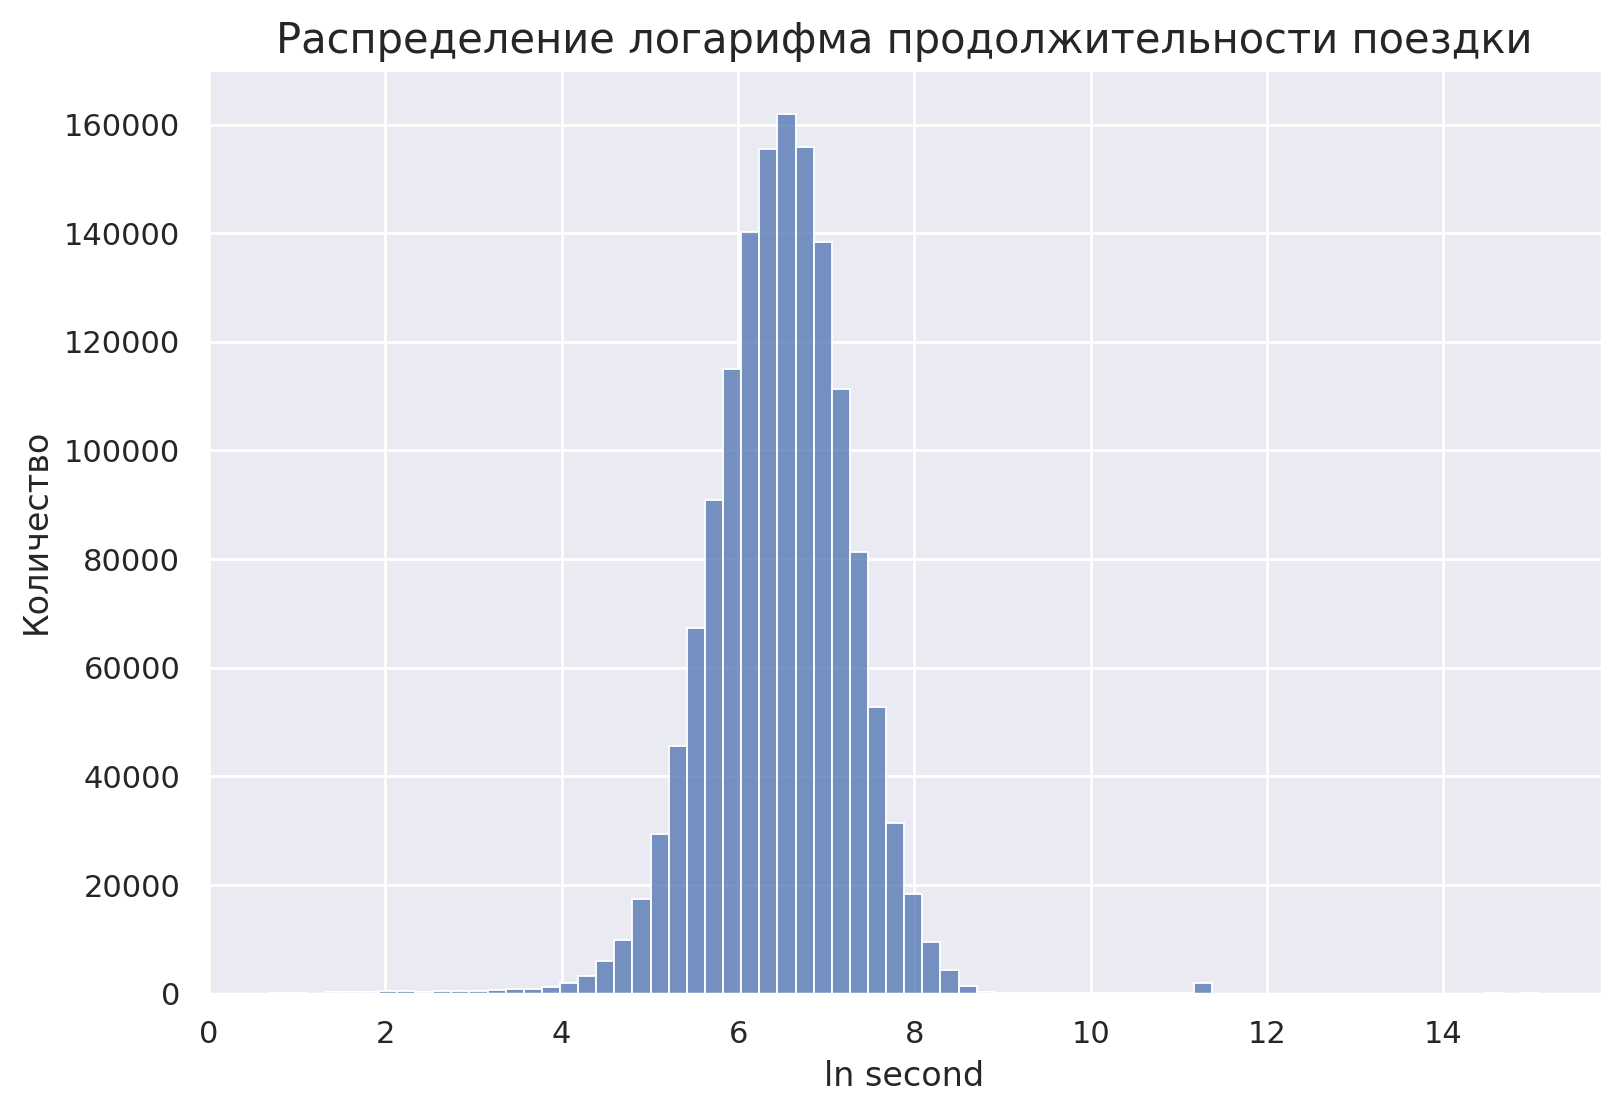

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Распределение логарифма продолжительности поездки', fontsize=15)
sns.histplot(df['log_trip_duration'], ax = ax, bins = 70)
ax.set_xlabel('ln second')
ax.set_ylabel('Количество')

Видим, что распределение логарифма напоминает нормальное.

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [10]:
def rmsle(log1p_y_true, log1p_y_pred):
  diff = log1p_y_true - log1p_y_pred
  return np.sqrt((diff.T @ diff)/diff.shape[0])

rmsle_best_const = rmsle(df['log_trip_duration'].to_numpy(), np.full_like(df['log_trip_duration'].to_numpy(), df['log_trip_duration'].mean()))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411537


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

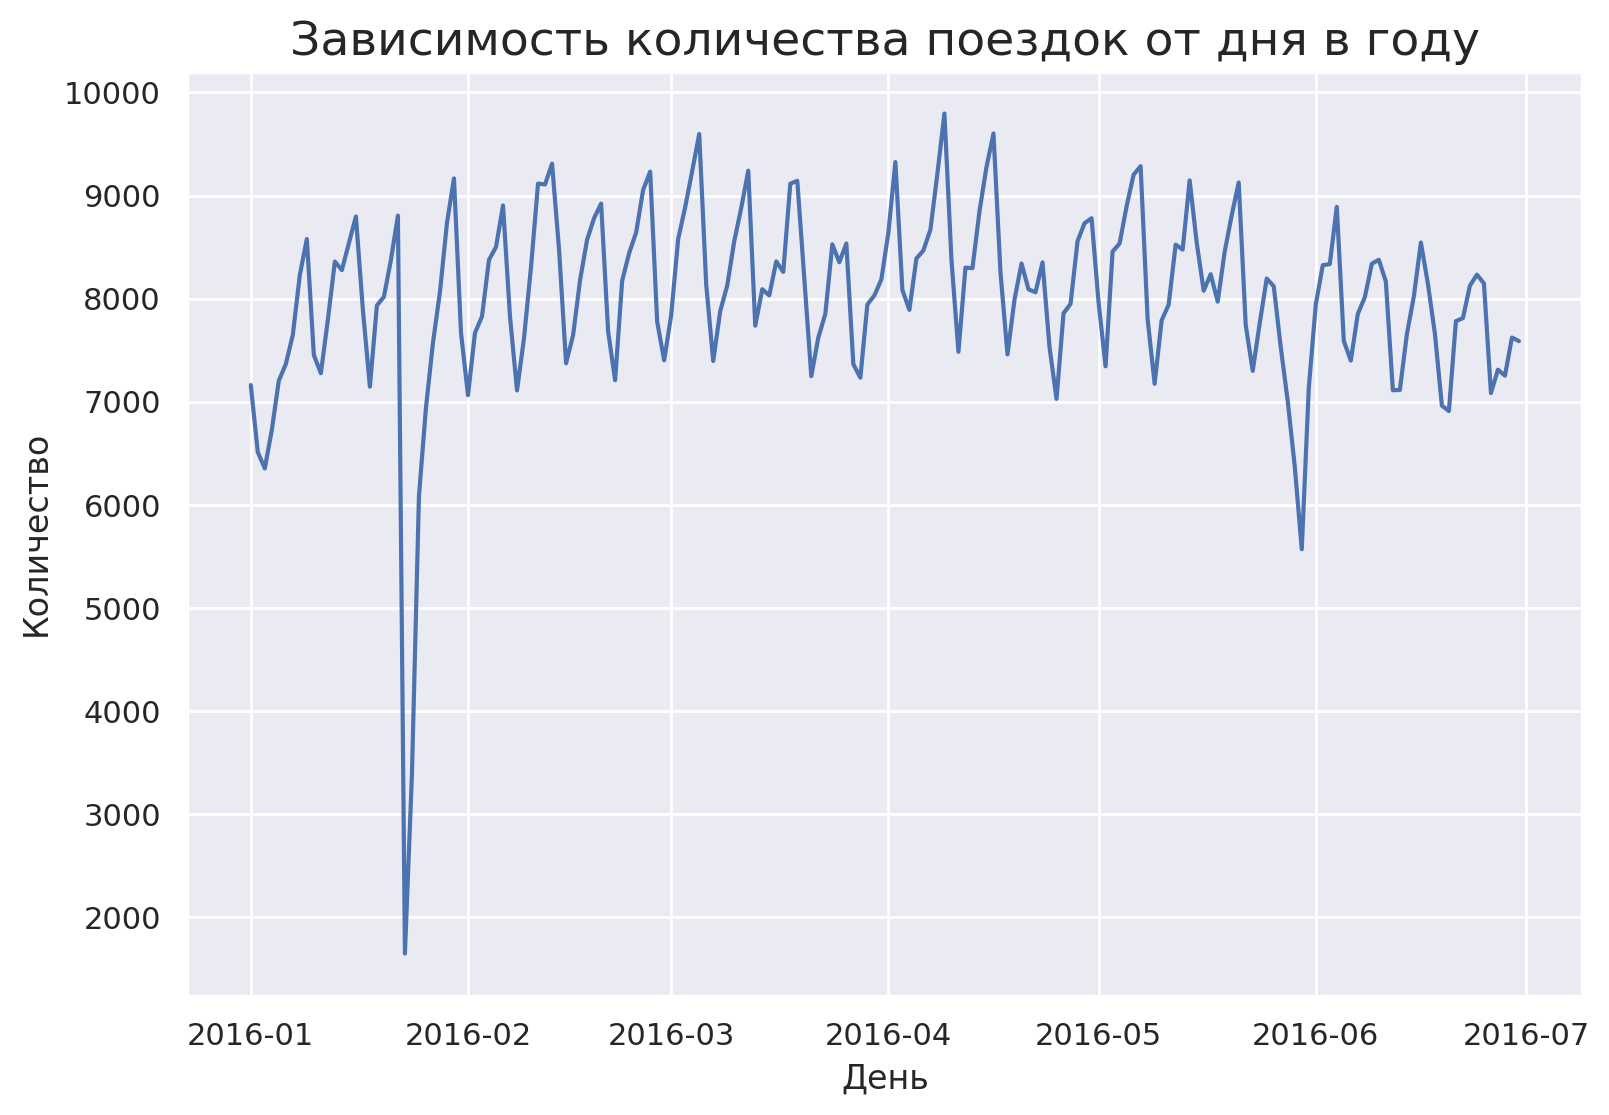

In [11]:
fig = plt.figure(figsize = (9, 6))
plt.plot(df.resample(rule = '1d', on = 'pickup_datetime', origin = 'start_day').count()['id'])


plt.title('Зависимость количества поездок от дня в году', fontsize = 17)
plt.xlabel('День')
plt.ylabel('Количество')




plt.show()

In [12]:
df.resample(rule = '1d', on = 'pickup_datetime', origin = 'start_day').count()['id'].idxmin()

Timestamp('2016-01-23 00:00:00')

In [13]:
df.loc[df['pickup_datetime'] > '2016-05-01'].resample(rule = '1d', on = 'pickup_datetime', origin = 'start_day').count()['id'].idxmin()

Timestamp('2016-05-30 00:00:00')

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

23.01.2016 - очень сильная [буря](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard).

30.05.2016 - [День поминовения](https://brightonbeachnews.com/rus/%d0%b4%d0%b5%d0%bd%d1%8c-%d0%bf%d0%be%d0%bc%d0%b8%d0%bd%d0%be%d0%b2%d0%b5%d0%bd%d0%b8%d1%8f-%d0%b2-%d0%bd%d1%8c%d1%8e-%d0%b9%d0%be%d1%80%d0%ba%d0%b5/) + [Стрельба в Гарлеме](https://nypost.com/2016/05/30/overnight-shootings-leave-six-injured/)

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

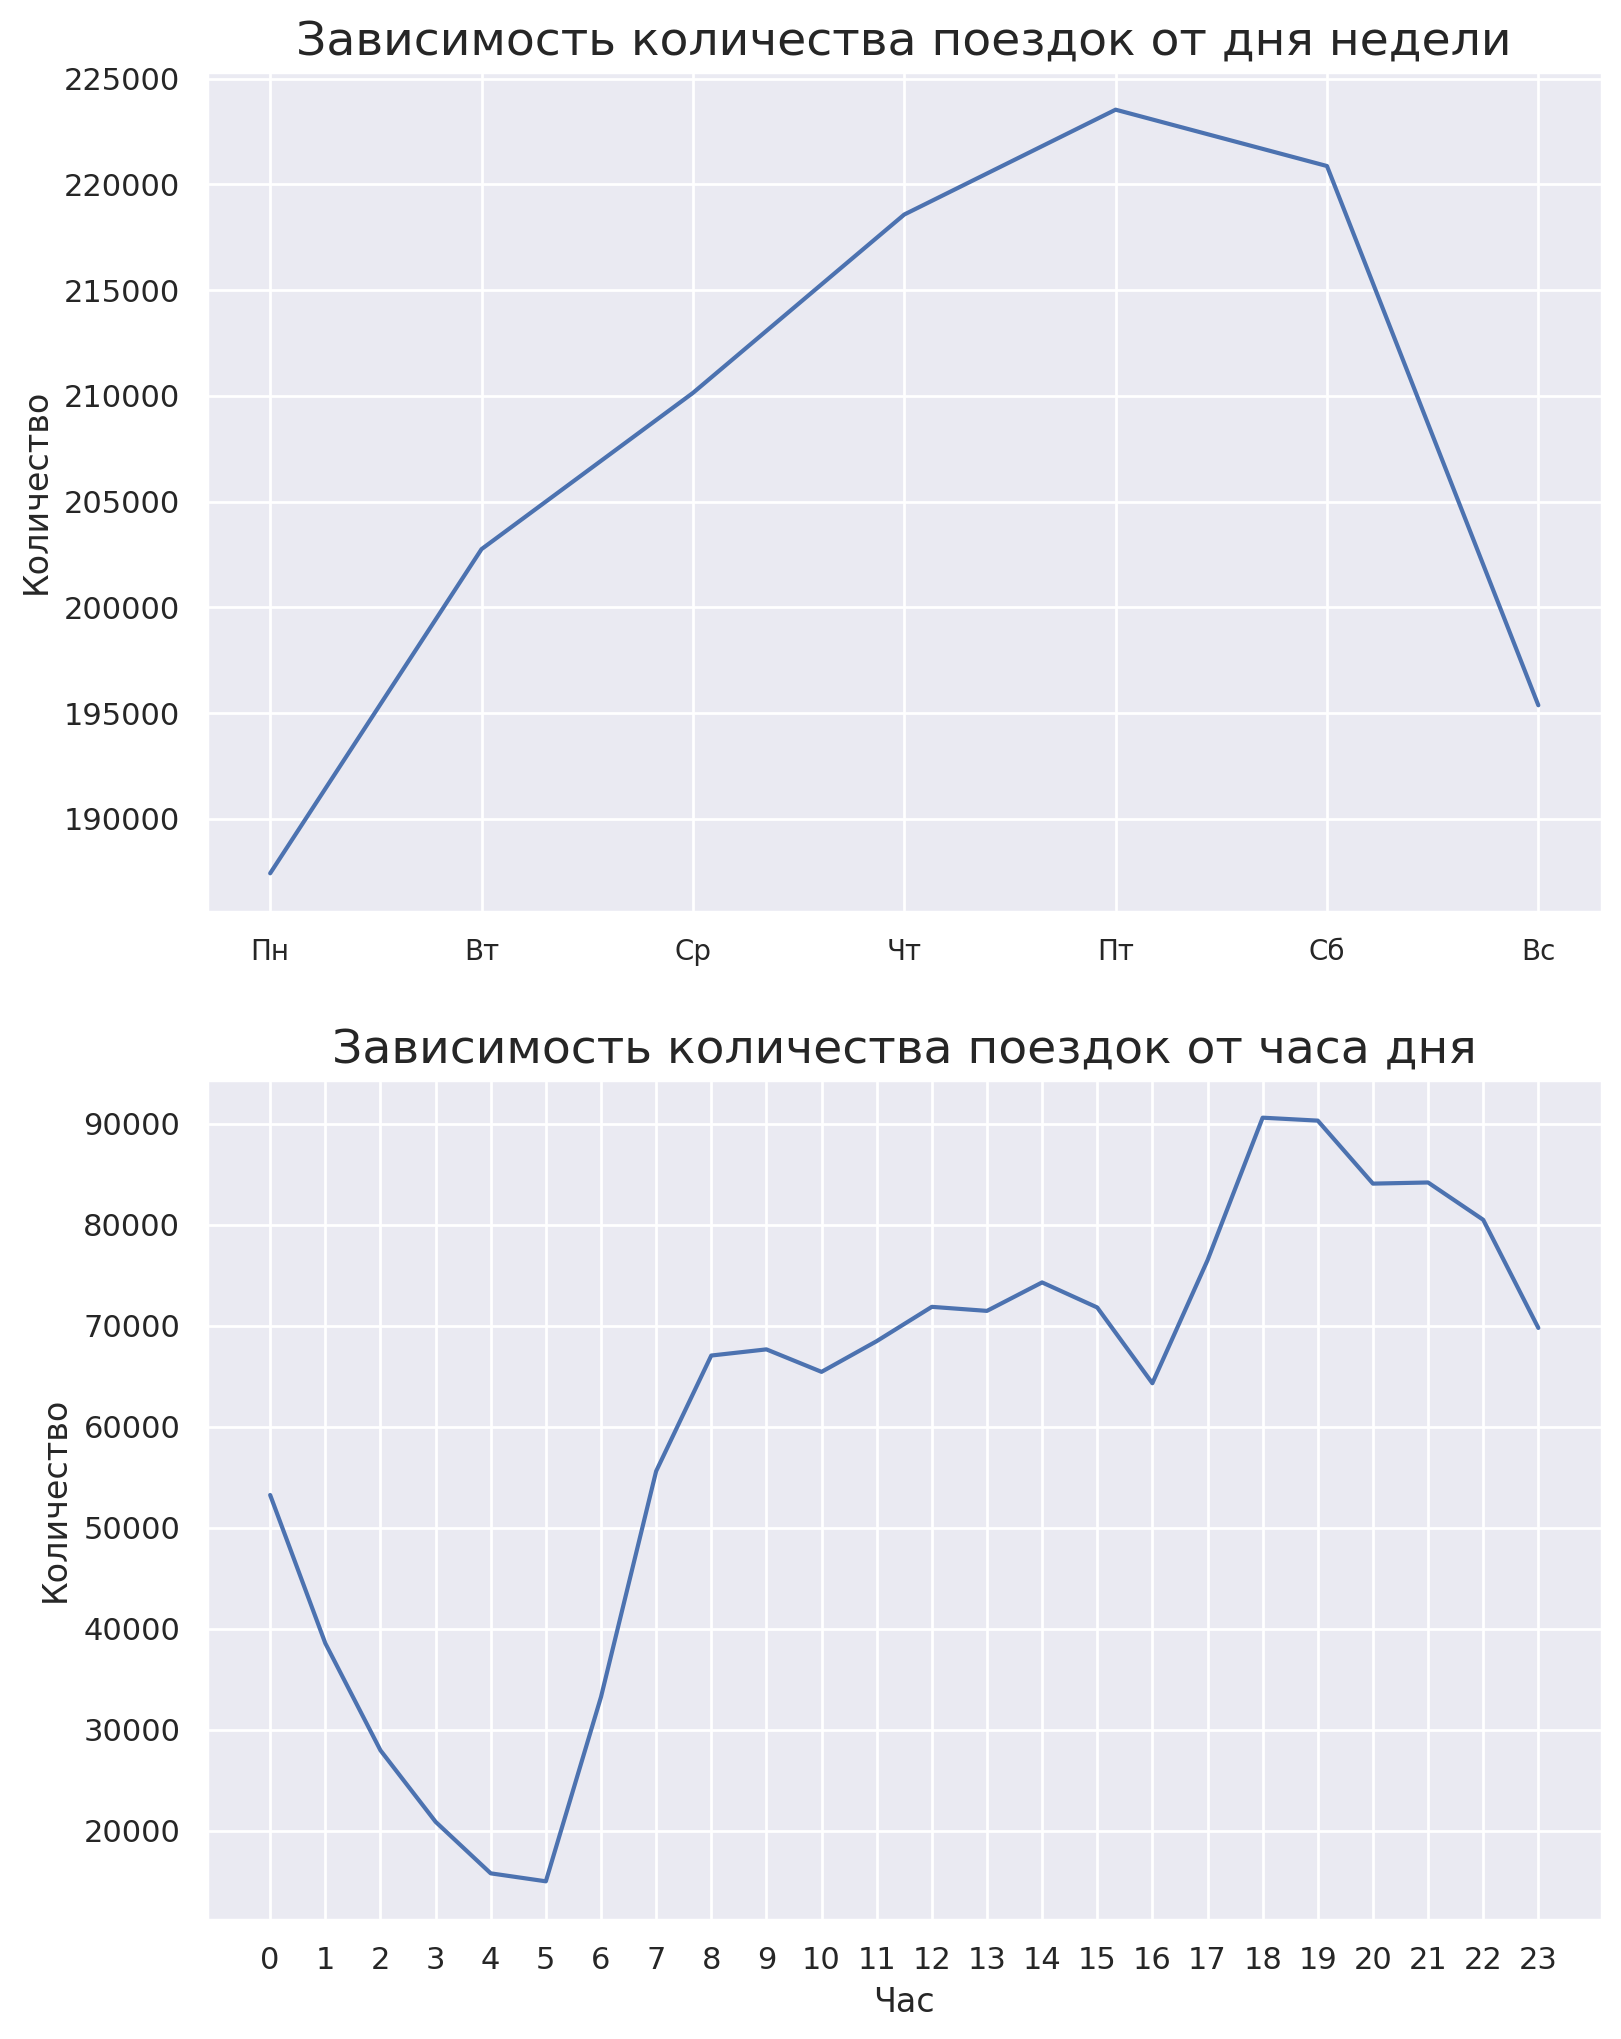

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(9, 12))
axes[0].plot(df.groupby(df['pickup_datetime'].dt.weekday).count()['id'])


axes[0].set_title('Зависимость количества поездок от дня недели', fontsize = 17)
axes[0].set_ylabel('Количество')
axes[0].set_xticks(ticks = range(7), labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], fontsize = 10)

axes[1].plot(df.groupby(df['pickup_datetime'].dt.hour).count()['id'])


axes[1].set_title('Зависимость количества поездок от часа дня', fontsize = 17)
axes[1].set_ylabel('Количество')
axes[1].set_xlabel('Час')
axes[1].set_xticks(ticks = np.arange(24))
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

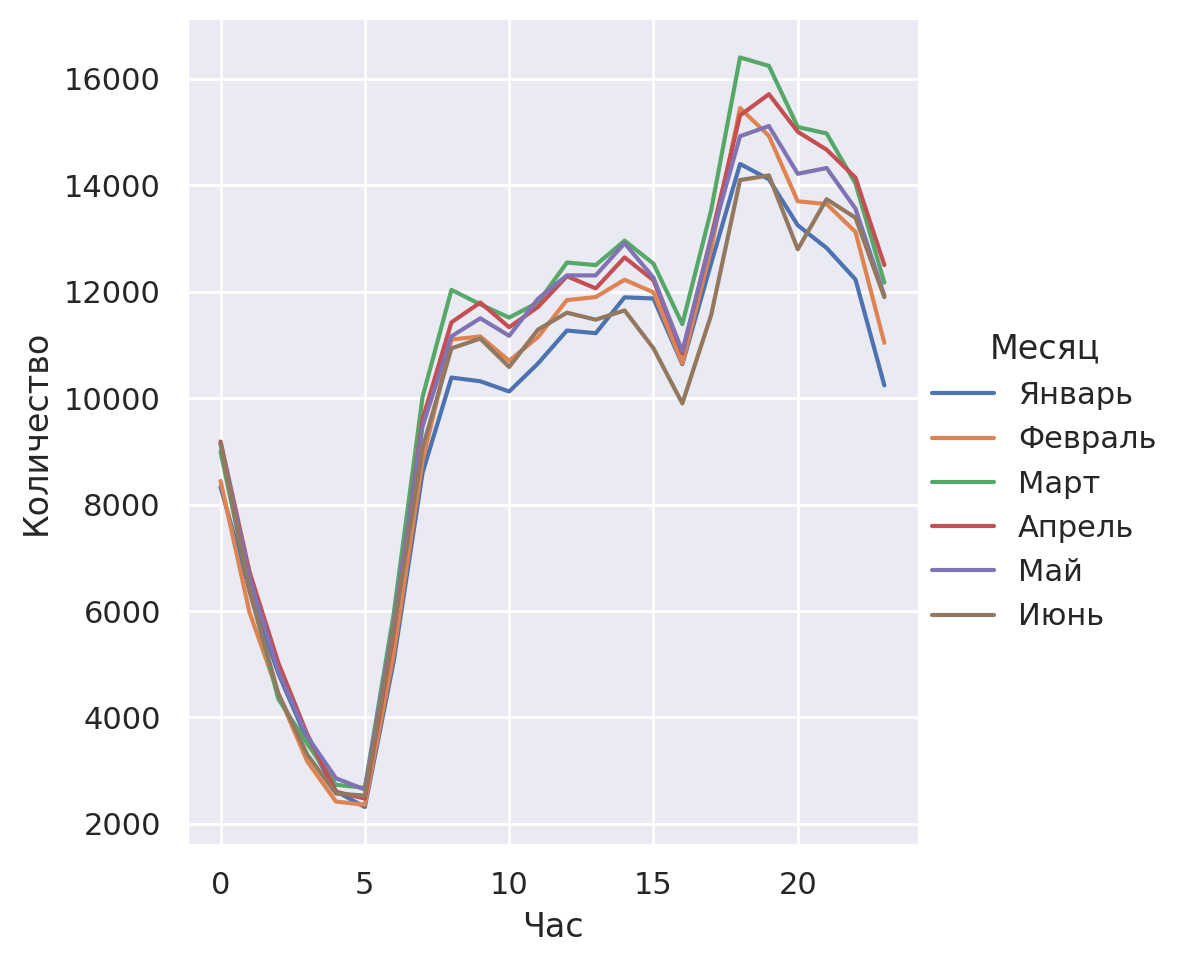

In [15]:
dfhm = df.groupby(by=[df['pickup_datetime'].dt.month, df['pickup_datetime'].dt.hour])['id'].count()
dfhm = dfhm.rename_axis(['Месяц', 'Час']).reset_index().rename(columns={'id':'Количество'})
dfhm = dfhm.replace({'Месяц': {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май', 6:'Июнь'}})
sns.relplot(data=dfhm, x="Час", y="Количество", hue="Месяц", kind='line')


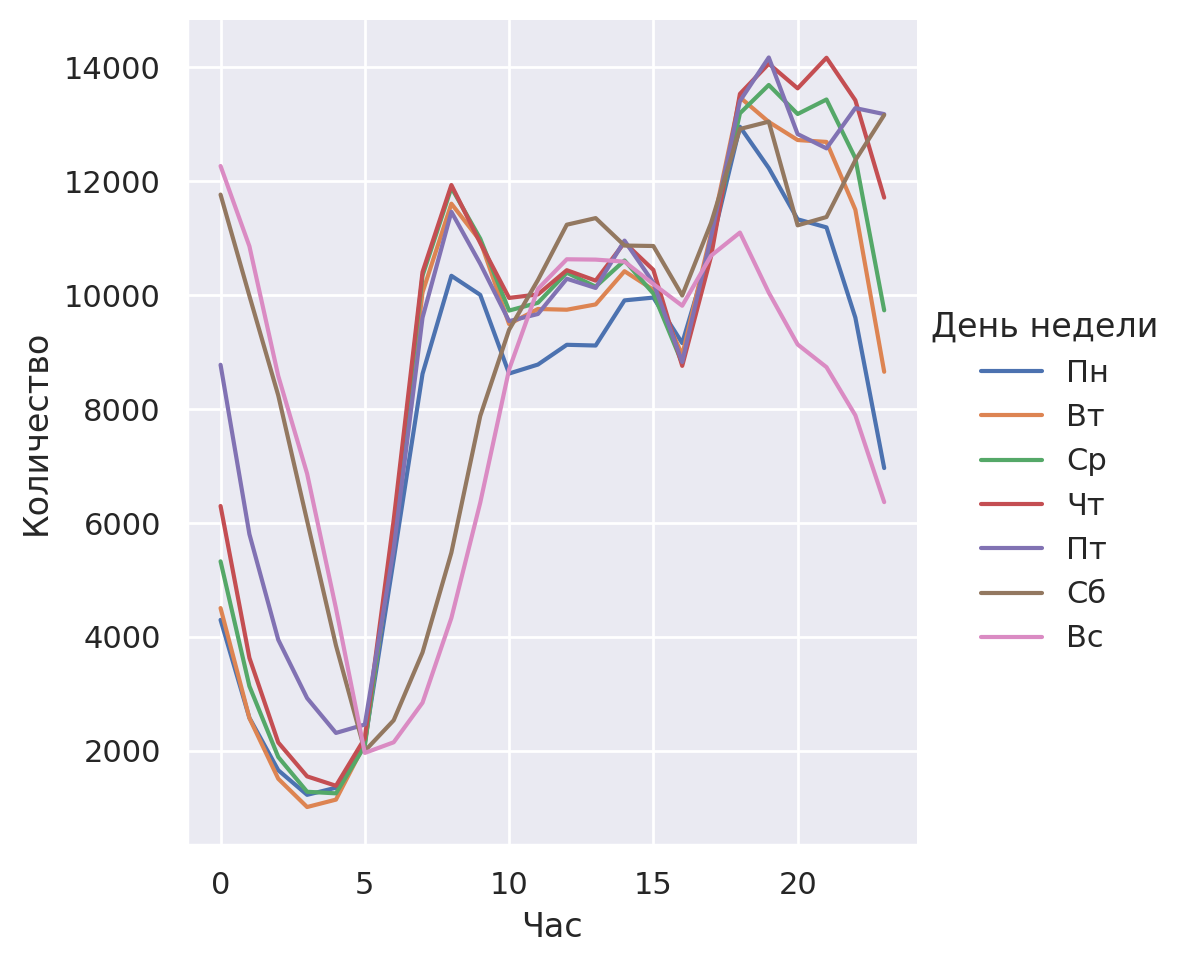

In [16]:
dfhw = df.groupby(by=[df['pickup_datetime'].dt.weekday, df['pickup_datetime'].dt.hour])['id'].count()
dfhw = dfhw.rename_axis(['День недели', 'Час']).reset_index().rename(columns={'id':'Количество'})
dfhw = dfhw.replace({'День недели': {0 : 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6:'Вс'}})
sns.relplot(data=dfhw, x="Час", y="Количество", hue="День недели", kind='line')

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Дни недели:
Количество поездок растет по будним дням с пиком в пятницу, после спадает. Понятно, почему пятница самый популярный день, рабочие хотят пораньше вернуться домой после работы или вернуться после отмечания конца недели. В рамках суток дни недели схожи, однако наблюдается, что воскресение более плавный день, чем остальные - действительно из-за того, что отдых не подвержен графику нет характерных час пиков.

Месяцы:
В раннее время суток количетство поездок во все месяцы более менее одинаковое. Различия наблюдаются в часы пиков. Мы получаем, что март - самый загруженный поездками месяц, а июнь наоборот - наименее. Объясняется двумя причинами.

1. Погодные условия. Предполагаю (в основном по песням Синатры), что март у жителей Нью-Йорка достаточно дождливый, а июнь наоборот солнечный. Соотвественно, в марте больше стимулов не лезть в печально известное метро и бродить по улице.

2. Июнь - месяц, когда люди начинают брать отпуска и ездить меньше.

Часы:

0 - 5 - уменьшение, люди идут спать.

5 - 8 - рост, люди едут на работу.

8 - 16 - стабильное количество поездок, рабочий день.

16 - 20 - рост, люди едут с работы, час пик.

20 - 0 - падение, люди ложаться спать.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

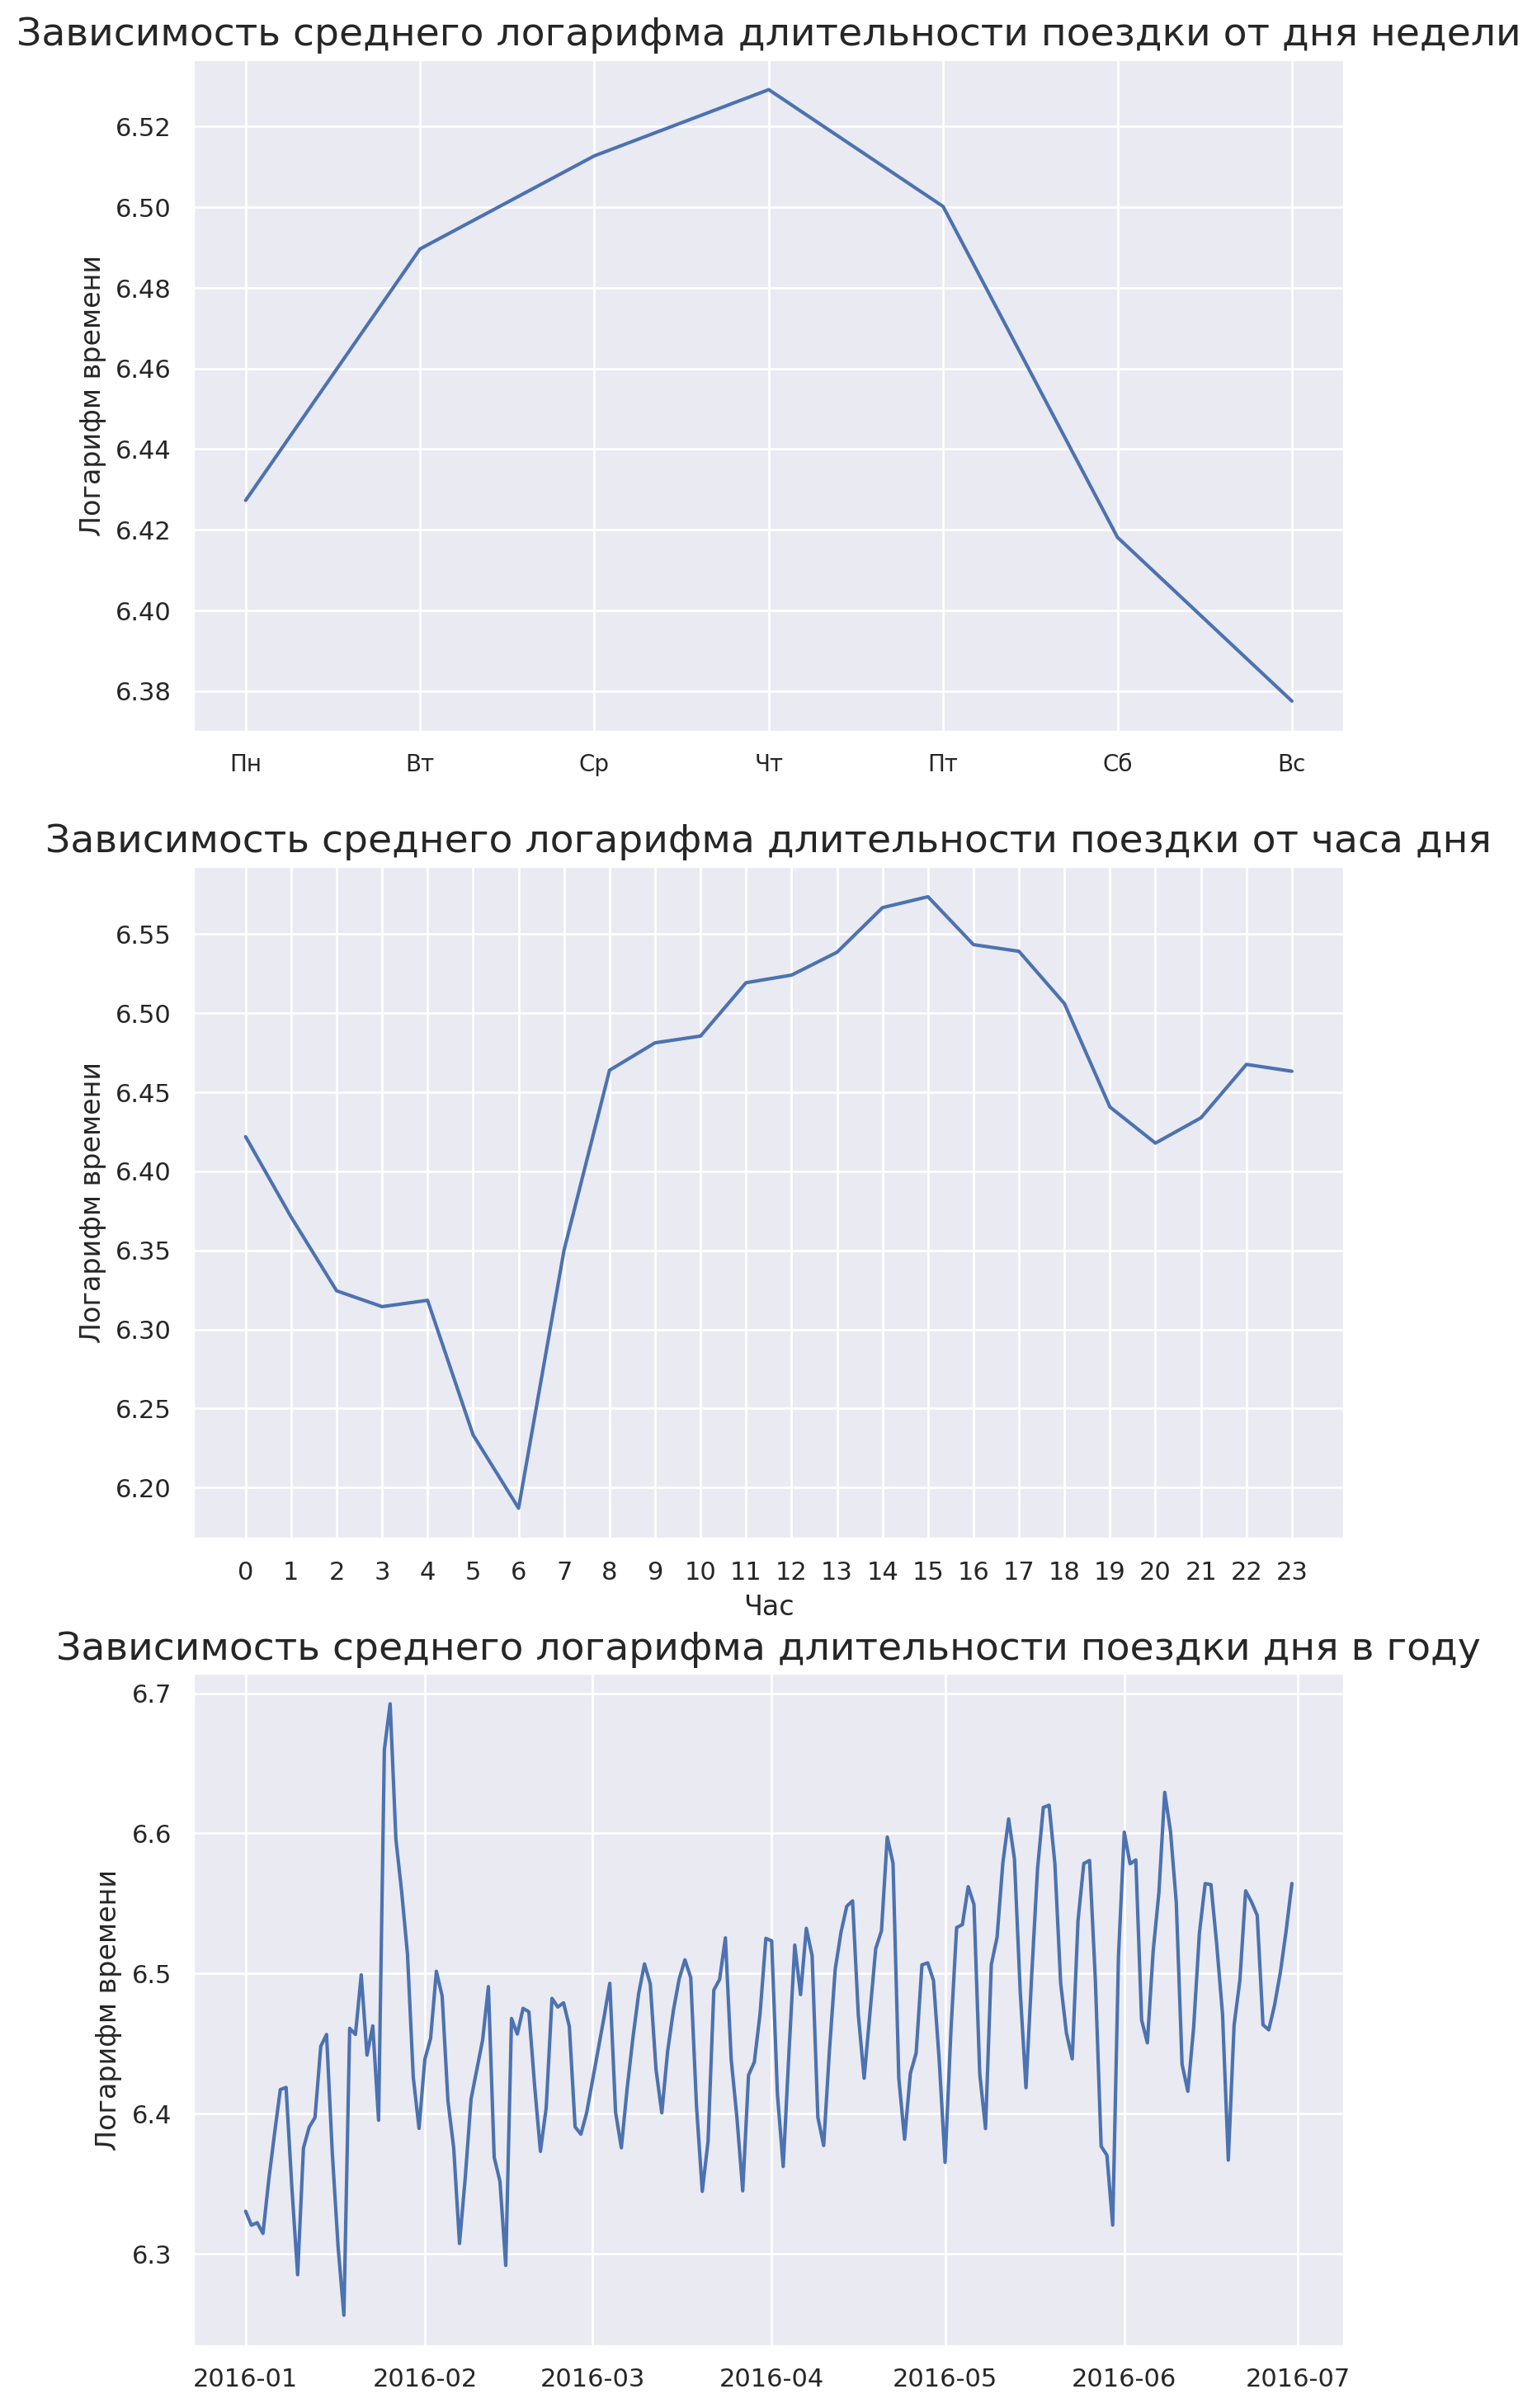

30997

In [17]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=10)

fig, axes = plt.subplots(3, 1, figsize=(9, 18))
axes[0].plot(df_train.groupby(df_train['pickup_datetime'].dt.weekday)['log_trip_duration'].mean())
axes[0].set_title('Зависимость среднего логарифма длительности поездки от дня недели', fontsize = 17)
axes[0].set_ylabel('Логарифм времени')
axes[0].set_xticks(ticks = range(7), labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], fontsize = 10)

axes[1].plot(df_train.groupby(df_train['pickup_datetime'].dt.hour)['log_trip_duration'].mean())
axes[1].set_title('Зависимость среднего логарифма длительности поездки от часа дня', fontsize = 17)
axes[1].set_ylabel('Логарифм времени')
axes[1].set_xlabel('Час')
axes[1].set_xticks(ticks = np.arange(24))


axes[2].plot(df_train.resample(rule = '1d', on = 'pickup_datetime', origin = 'start_day')['log_trip_duration'].mean())
axes[2].set_title('Зависимость среднего логарифма длительности поездки дня в году', fontsize = 17)
axes[2].set_ylabel('Логарифм времени')
plt.show()

gc.collect()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Да, они похожи, разве что средний логарифм времени чуть более гладкий. Связано это с тем, что:
1. График от часов: ночью не работает общественный транспорт и освещение, следовательно горожане чаще будут заказывать такси, на короткие расстояния. Днем, наоборот скорее будут заказывать те, которым дальше добираться.
2. Графики от дней недели и дней года: в выходные и праздники чаще будут заказывать такси на короткие расстояния, так как в эти дни могут быть сокращенные расписания общественного транспорта. Кроме того, в эти дни люди более склонны ехать на такси, так как больше ценят комфорт поездки на выходных. Следовательно, больше коротких поездок.

В аномальные дни средний логарифм ведет себя разным образом. В случае Дня поминовения, причины аналогичные выходным дням и логарифм падает. В случае бури, он резко возрастает. Это можно объяснить тем, что в связи с аномальными погодными условиями, люди будут стараться сидеть дома и для этого отменят часть планов. Остануться только неотложные поездки: до больницы, до и от аэропорта, вокзалов. В среднем, рационально предположить, что такие поездки более долгие, следовательно среднее время резко вырастет.

Существует легкий положительный тренд по мере приближения лета. Можно связать это с тем, что при более негативных погодных условиях, люди чаще заказывают такси на короткое расстояние. В летние дни же то же короткое расстояние легче пройти или преодолеть на общественном транспорте, чем зимой.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [18]:
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month'] = df['pickup_datetime'].dt.month
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['weekday'].astype("object")
df['month'] = df['month'].astype("object")
df['hour'] = df['hour'].astype("object")

df['day'] = df['pickup_datetime'].dt.dayofyear
df['blizzard'] = (df['day'] == 23)
df['memorial_day'] = (df['day'] == 151)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

1. День в году - численный. У нас есть легкий положительный тренд на графике зависимости + если кодировать признаки их будет слишком много. Более чем оправдано использовать его как число.
2. Буря, День поминовения - это уже бинарные категориальный признаки, по их определению.
3. Месяц - категориальный признак. Сгладит тренд от дня в году, учтет легкие колебания от месяцев несоответствующие тренду? Не вижу смысла использовать, так как отвечает за тот же тренд что и дни. И вероятно дал бы большую корелляцию будь он числовым, поэтому будет категориальным.
4. Неделя, час - категориальные. Зависимость времени поездки от них нелинейна, поэтому имеет смысл их закодировать и рассматривать так.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.loc[:,'weekday':'memorial_day']
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


numeric_features = X[['day']].columns
categorical_features = X.drop(columns=['day']).columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features) # Да, признак единственный, поэтому в масштабировании смысла нет. Скейлер оставил, потому что в задании указано + на будущее.
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("Train RMSLE = %.4f" % root_mean_squared_error(y_train, y_train_pred))
print("Test RMSLE = %.4f" % root_mean_squared_error(y_test, y_pred))


gc.collect()

Train RMSLE = 0.7894
Test RMSLE = 0.7874


100

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [20]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [21]:
sample = df.sample(1000)
your_lat_values = sample.pickup_latitude
your_lon_values = sample.pickup_longitude

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Выделяются:
1. Аэропорт имени JFK
2. Аэропорт Ла гвардия
3. Манхэттен

Почему выделяются аэропорты очевидно. Это крупные международные аэропорты в огроном городе. Постоянные прилеты новых пассажиров, часть из которых предпочитает добирать домой на такси. Что и создает существенный трафик.

Манхэттен - Уолл-стрит, Бродвей, да и множество других улиц в историческом центр Нью-Йорка, где расположены небоскребы с офисами крупнейших компаний мира. Постоянный приток/отток сотрудников множества фирм с окраин города. Что создает большое количество трафика. Считаем основным облаком точек.


**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [22]:
def haversine_array(lat1, lng1, lat2, lng2): # с семинара
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

df['haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
df.sample(5)

id  vendor_id     pickup_datetime  passenger_count  \
789194  id3223134          1 2016-02-21 12:47:20                1   
83273   id2362161          1 2016-06-29 19:01:17                1   
408485  id1007238          2 2016-04-15 23:38:14                1   
185645  id0837586          1 2016-01-28 11:48:24                1   
778214  id1674375          2 2016-06-13 21:59:02                1   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
789194        -73.976860        40.760284         -73.990891   
83273         -73.991112        40.739353         -73.993454   
408485        -74.011223        40.715031         -73.942810   
185645        -73.982140        40.772465         -73.967056   
778214        -73.998444        40.745216         -73.983185   

        dropoff_latitude store_and_fwd_flag  log_trip_duration weekday month  \
789194         40.734146                  N           6.309918       6     2   
83273          40.730537                  N           5.613128       2     6   
408485         40.675732                  N           7.370231       4     4   
185645         40.766647                  N           6.401917       3     1   
778214         40.726727                  N           6.326149       0     6   

       hour  day  blizzard  memorial_day  haversine  
789194   12   52     False         False   3.137581  
83273    19  181     False         False   0.999936  
408485   23  106     False         False   7.236112  
185645   11   28     False         False   1.425432  
778214   21  165     False         False   2.424848

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [23]:
df['log_haversine'] = np.log1p(df['haversine'])

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

Text(0.5, 1.0, 'Матрица корелляций для признаков')

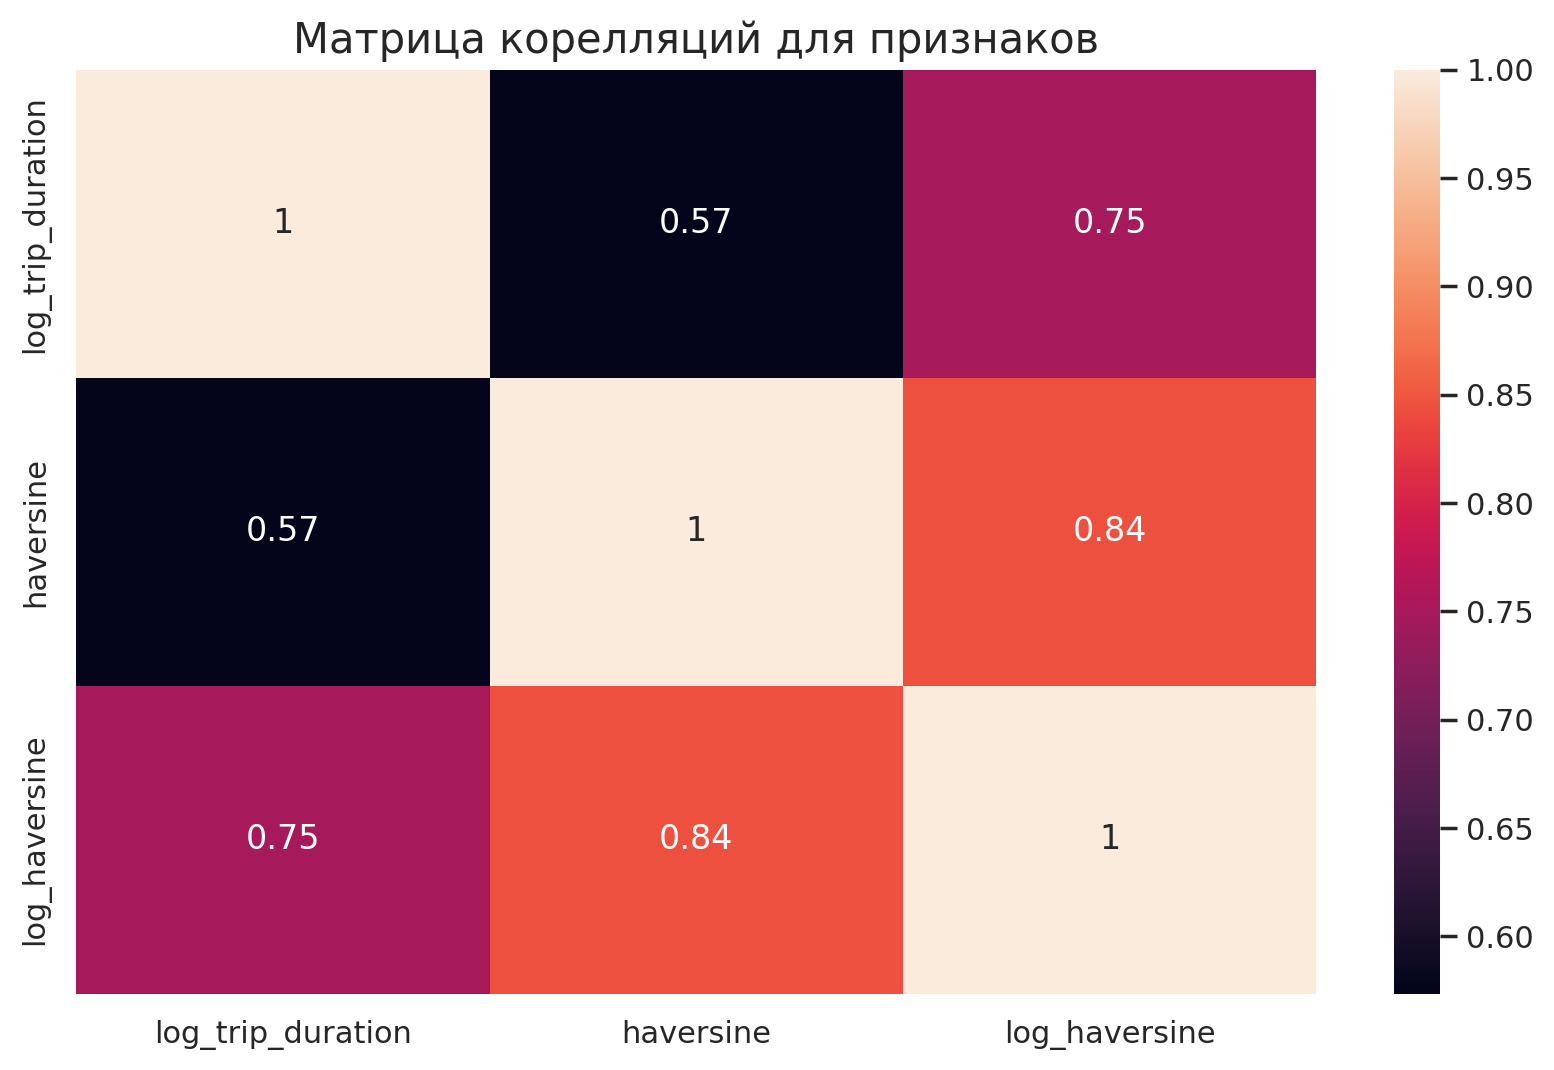

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(data=df[['log_trip_duration', 'haversine', 'log_haversine']].corr(), ax=ax, annot=True)
ax.set_title('Матрица корелляций для признаков', fontsize = 15)

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

188

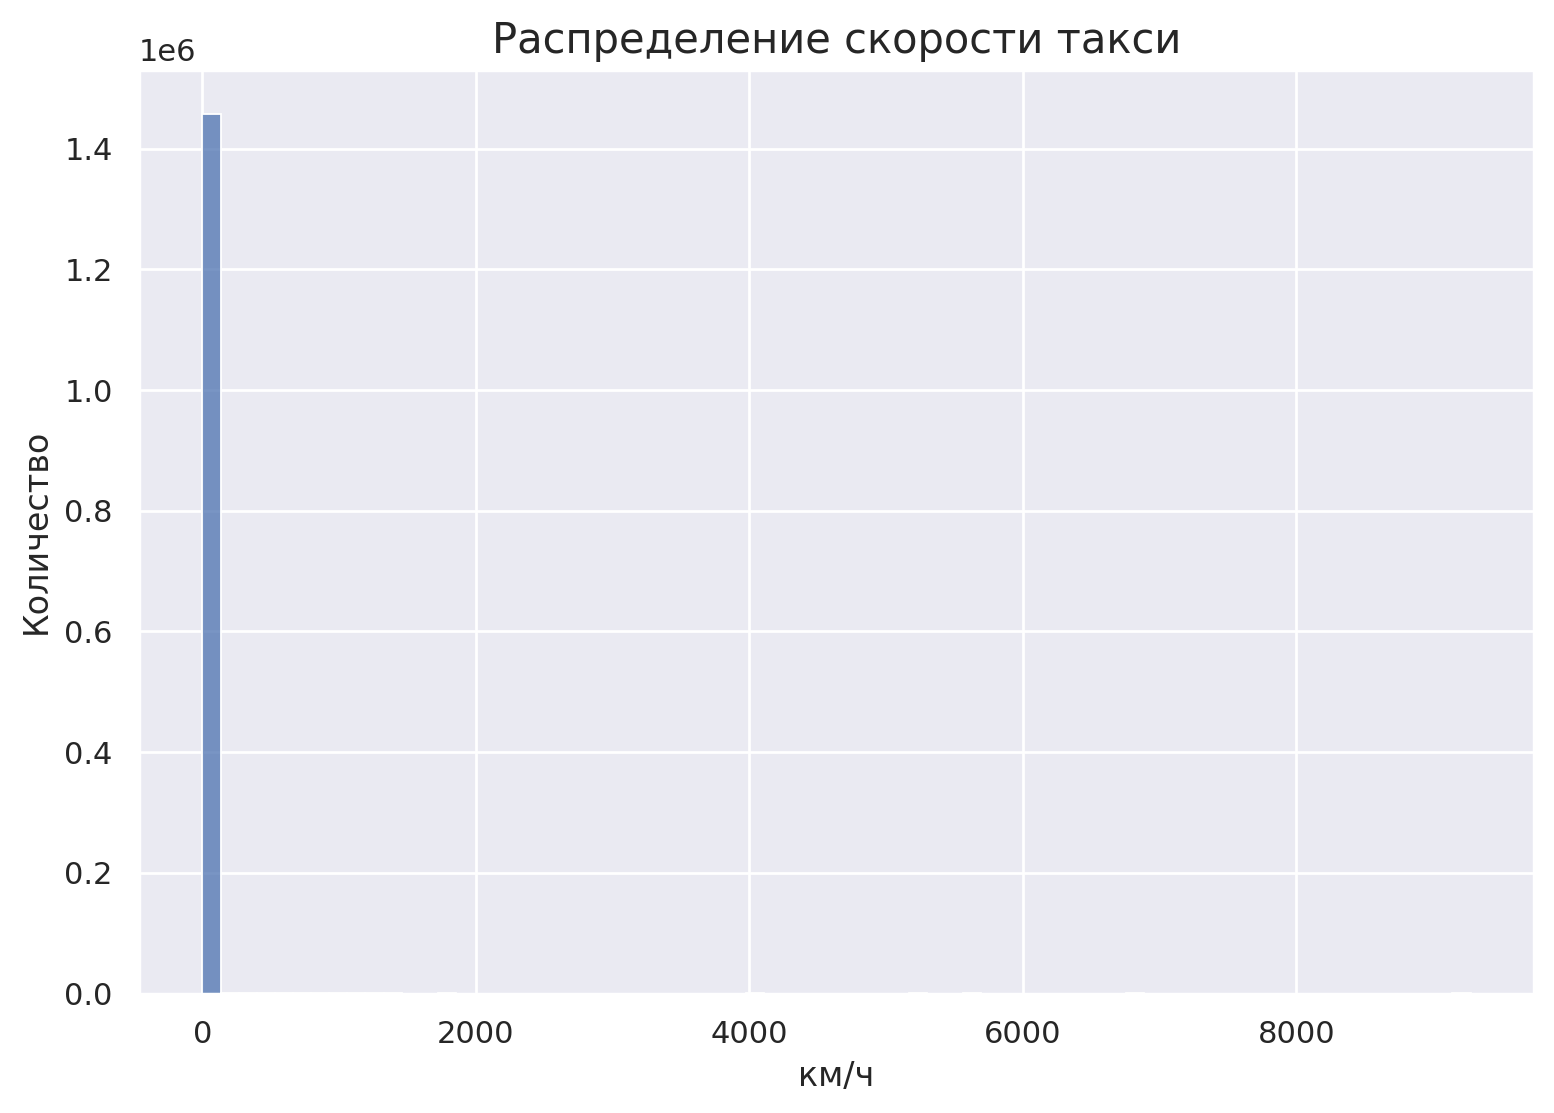

In [25]:
fig, ax = plt.subplots(figsize=(9, 6))
velocity = 3600*df['haversine']/(np.expm1(df['log_trip_duration']))  #А зачем мы удаляли...
ax = sns.histplot(velocity, ax = ax, bins = 70) # В выборке снова имеются нереалистичные выбросы
ax.set_title('Распределение скорости такси', fontsize=15)
ax.set_xlabel('км/ч')
ax.set_ylabel('Количество')

gc.collect()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

Text(0, 0.5, 'Количество')

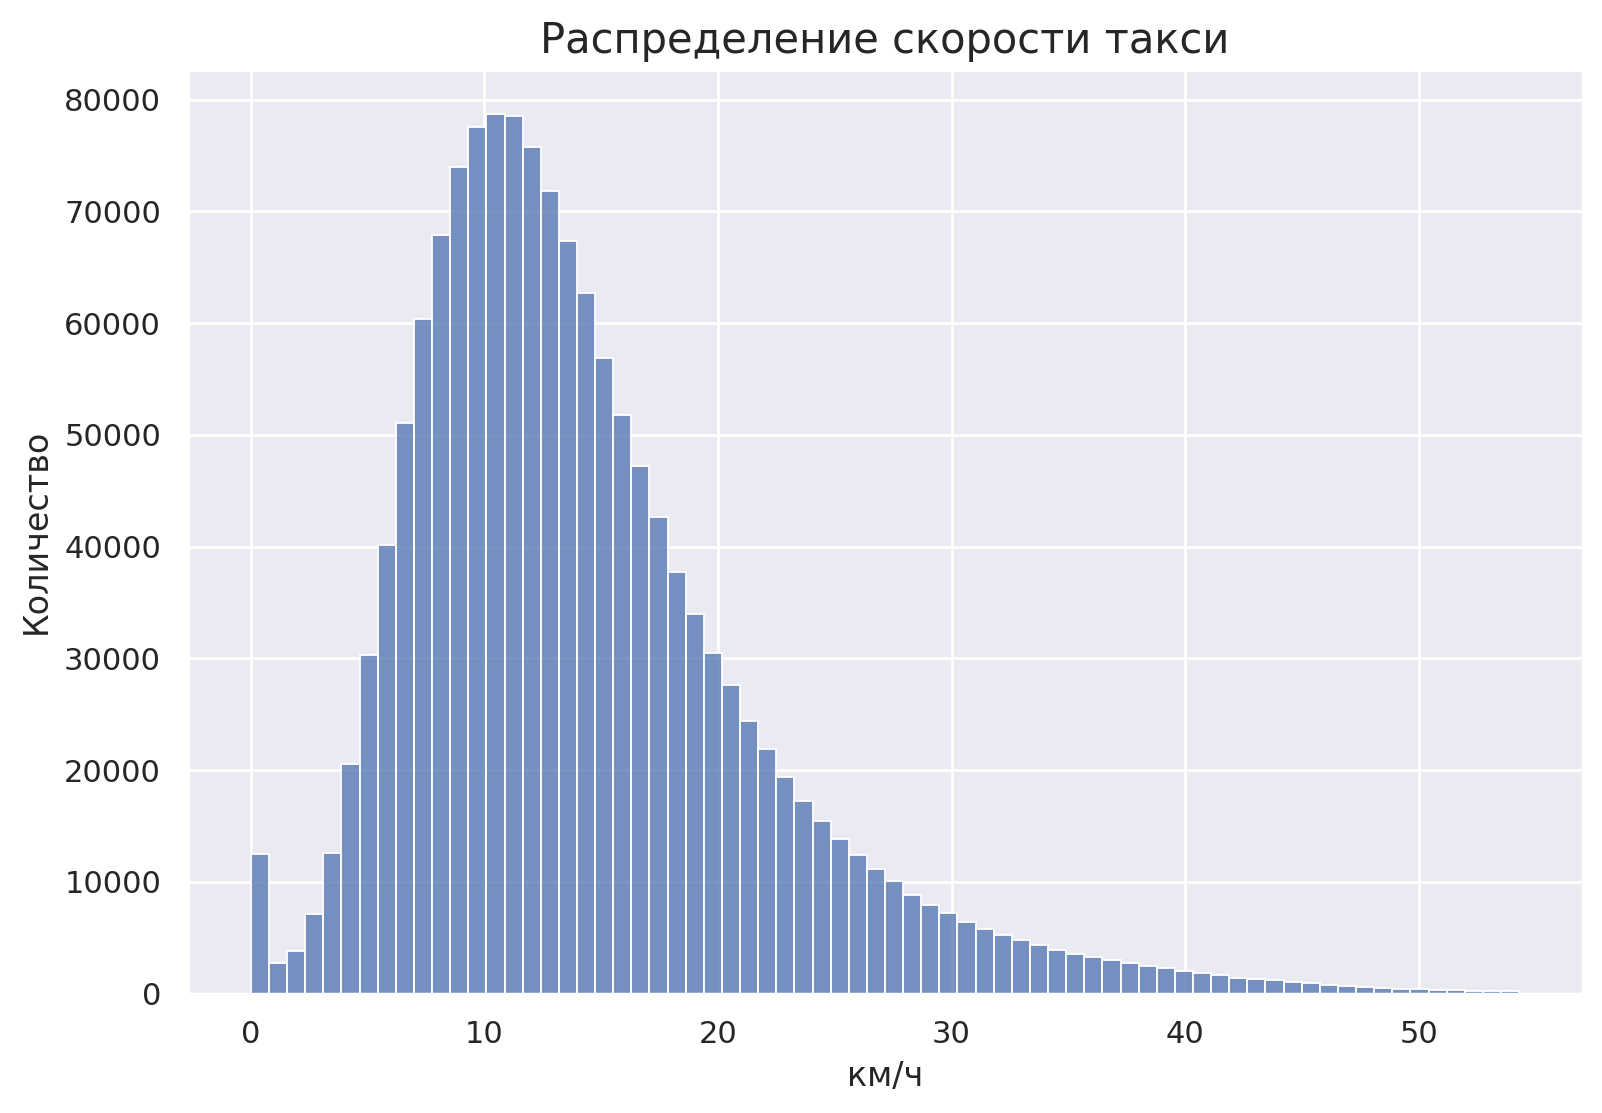

In [26]:
fig, ax = plt.subplots(figsize=(9, 6))
velocity = 3600*df['haversine']/(np.expm1(df['log_trip_duration']))  #А зачем мы удаляли...
ax = sns.histplot(velocity[velocity <= np.percentile(velocity, 99.9)], ax = ax, bins = 70) # В выборке снова имеются нереалистичные выбросы, отбросим их 99.9% перцентилем
ax.set_title('Распределение скорости такси', fontsize=15)
ax.set_xlabel('км/ч')
ax.set_ylabel('Количество')

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

Text(78.75, 0.5, 'Час')

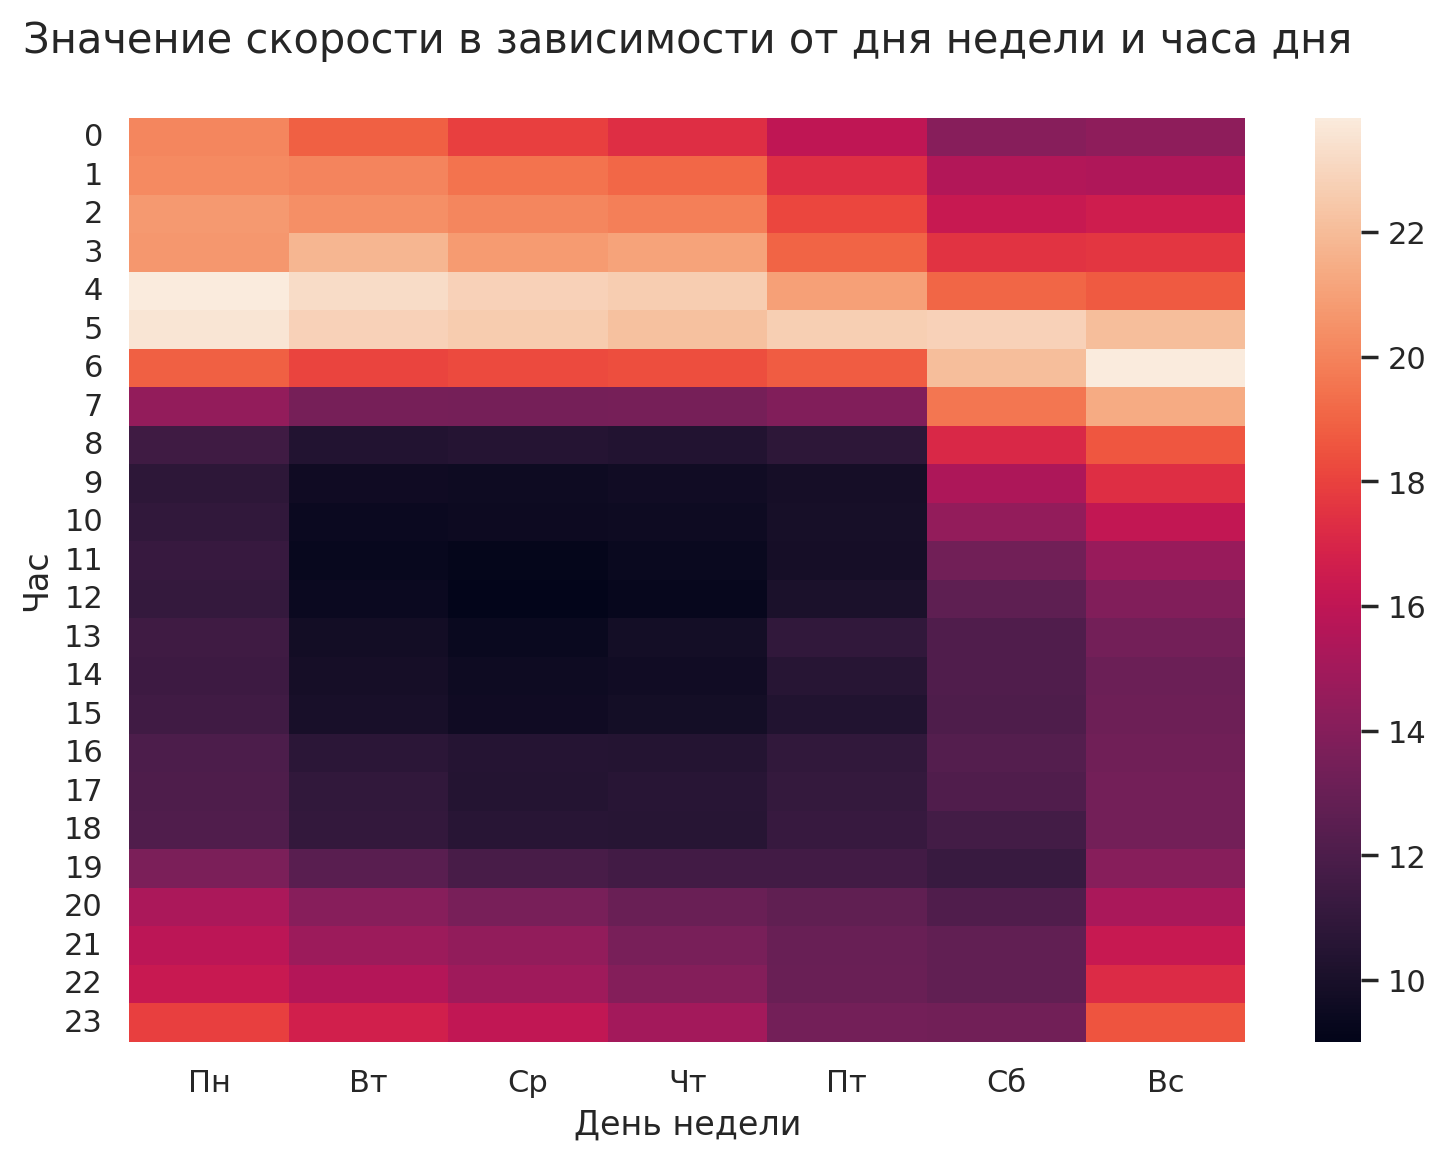

In [27]:
df['velocity'] = velocity
vel = pd.pivot_table(data=df[['velocity', 'weekday', 'hour']], index='hour', columns='weekday', values='velocity', aggfunc="median")
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(vel, ax=ax, xticklabels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
ax.set_title('Значение скорости в зависимости от дня недели и часа дня\n',  fontsize=15)
ax.set_xlabel('День недели', fontsize=12)
ax.set_ylabel('Час', fontsize=12)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Целевая переменная линейно зависит от неё и расстояния, что приводит к мультиколлинеарности. Признаки сильно коррелируют, из-за чего возникают большие веса и переобучение.

In [28]:
df = df.drop(columns=['velocity'])

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Минимальна скорость в среднем с 9 до 12 часов в будние дни, что отражает час пик. Как следствие пробки.

Максимальна в 4, 5 утра - большая часть горожан спит, трафика на дорогах мало.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

Периодом пробок обозначим время с 8 до 19 по будням, с 11 до 19 в субботу и с 13 до 19 в воскресение, этот промежуток больше, чем изначально обозначенный, но там я говорил о минимуме, тут же о том, когда скорость в целом существенно ниже.

Периодом свободных дорог обозначим время с 4 до 5 утра по будням, с 5 до 6 по выходным.

In [29]:
df['traffic_jams'] = (((df['hour'] >= 8) & (df['hour'] <= 19) & (df['weekday'] <= 4)) | ((df['hour'] >= 11) & (df['hour'] <= 19) & (df['weekday'] == 5)) | \
                      ((df['hour'] >= 13) & (df['hour'] <= 19) & (df['weekday'] == 6)))
df['traffic_free'] = (((df['hour'] >= 4) & (df['hour'] <= 5) & (df['weekday'] <= 4))|((df['hour'] >= 5) & (df['hour'] <= 6) & (df['weekday'] > 4)))

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?
Признаки полезны по схожей с пробками причинами, там эти пробки появляются - в местах наибольшего трафика.

Делать будем так:

Аэропорты сравнительно небольшие и хорошо вписываются в окружность. Определим признак по близости к геометрическим центрам портов.

Манхэттен - является основным облаком точек, его не выделяем как отдельный признак.

In [30]:
def check_rad(x, y, lat, long, r):
  return haversine_array(x,y, lat, long) < r
df['jfk_pickup'] = check_rad(df['pickup_latitude'].values, df['pickup_longitude'].values, 40.64890932259944, -73.79070924968052, 3)
df['jfk_dropoff'] = check_rad(df['dropoff_latitude'].values, df['dropoff_longitude'].values, 40.64890932259944, -73.79070924968052, 3)
df['lguard_pickup'] = check_rad(df['pickup_latitude'].values, df['pickup_longitude'].values, 40.77743975629017, -73.87490152047523, 1.6)
df['lguard_dropoff'] = check_rad(df['dropoff_latitude'].values, df['dropoff_longitude'].values, 40.77743975629017, -73.87490152047523, 1.6)
#df['manhattan_pickup'] =  check_rad(df['pickup_latitude'].values, df['pickup_longitude'].values, 40.723040325832635, -73.99844338091438, 3) | \
# check_rad(df['pickup_latitude'].values, df['pickup_longitude'].values, 40.74844700123574, -73.98615610947634, 3) | \
# check_rad(df['pickup_latitude'].values, df['pickup_longitude'].values, 40.77453448828552, -73.96939893515474, 3)
#df['manhattan_dropoff'] = check_rad(df['dropoff_latitude'].values, df['dropoff_longitude'].values, 40.723040325832635, -73.99844338091438, 3) | \
# check_rad(df['dropoff_latitude'].values, df['dropoff_longitude'].values, 40.74844700123574, -73.98615610947634, 3) | \
# check_rad(df['dropoff_latitude'].values, df['dropoff_longitude'].values, 40.77453448828552, -73.96939893515474, 3)
df.sample(5)

id  vendor_id     pickup_datetime  passenger_count  \
1107676  id1211062          2 2016-01-07 08:51:02                5   
414228   id3060215          1 2016-04-28 13:42:38                1   
853431   id1959554          1 2016-04-27 03:18:45                1   
1442077  id0781022          2 2016-05-11 12:42:05                6   
1304311  id3261743          2 2016-01-14 19:11:29                3   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
1107676        -74.001060        40.741821         -73.978577   
414228         -73.997116        40.723881         -74.008064   
853431         -74.002647        40.734421         -73.953972   
1442077        -73.863693        40.769707         -73.986336   
1304311        -73.984543        40.779251         -73.967102   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  ... blizzard  \
1107676         40.745171                  N           6.717805  ...    False   
414228          40.731003                  N           6.455199  ...    False   
853431          40.662151                  N           7.050123  ...    False   
1442077         40.758537                  N           8.102586  ...    False   
1304311         40.765141                  N           6.536692  ...    False   

        memorial_day  haversine  log_haversine  traffic_jams  traffic_free  \
1107676        False   1.930429       1.075149          True         False   
414228         False   1.215844       0.795633          True         False   
853431         False   9.023071       2.304890         False         False   
1442077        False  10.403292       2.433902          True         False   
1304311        False   2.149150       1.147132          True         False   

         jfk_pickup  jfk_dropoff  lguard_pickup  lguard_dropoff  
1107676       False        False          False           False  
414228        False        False          False           False  
853431        False        False          False           False  
1442077       False        False           True           False  
1304311       False        False          False           False  

[5 rows x 24 columns]

Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

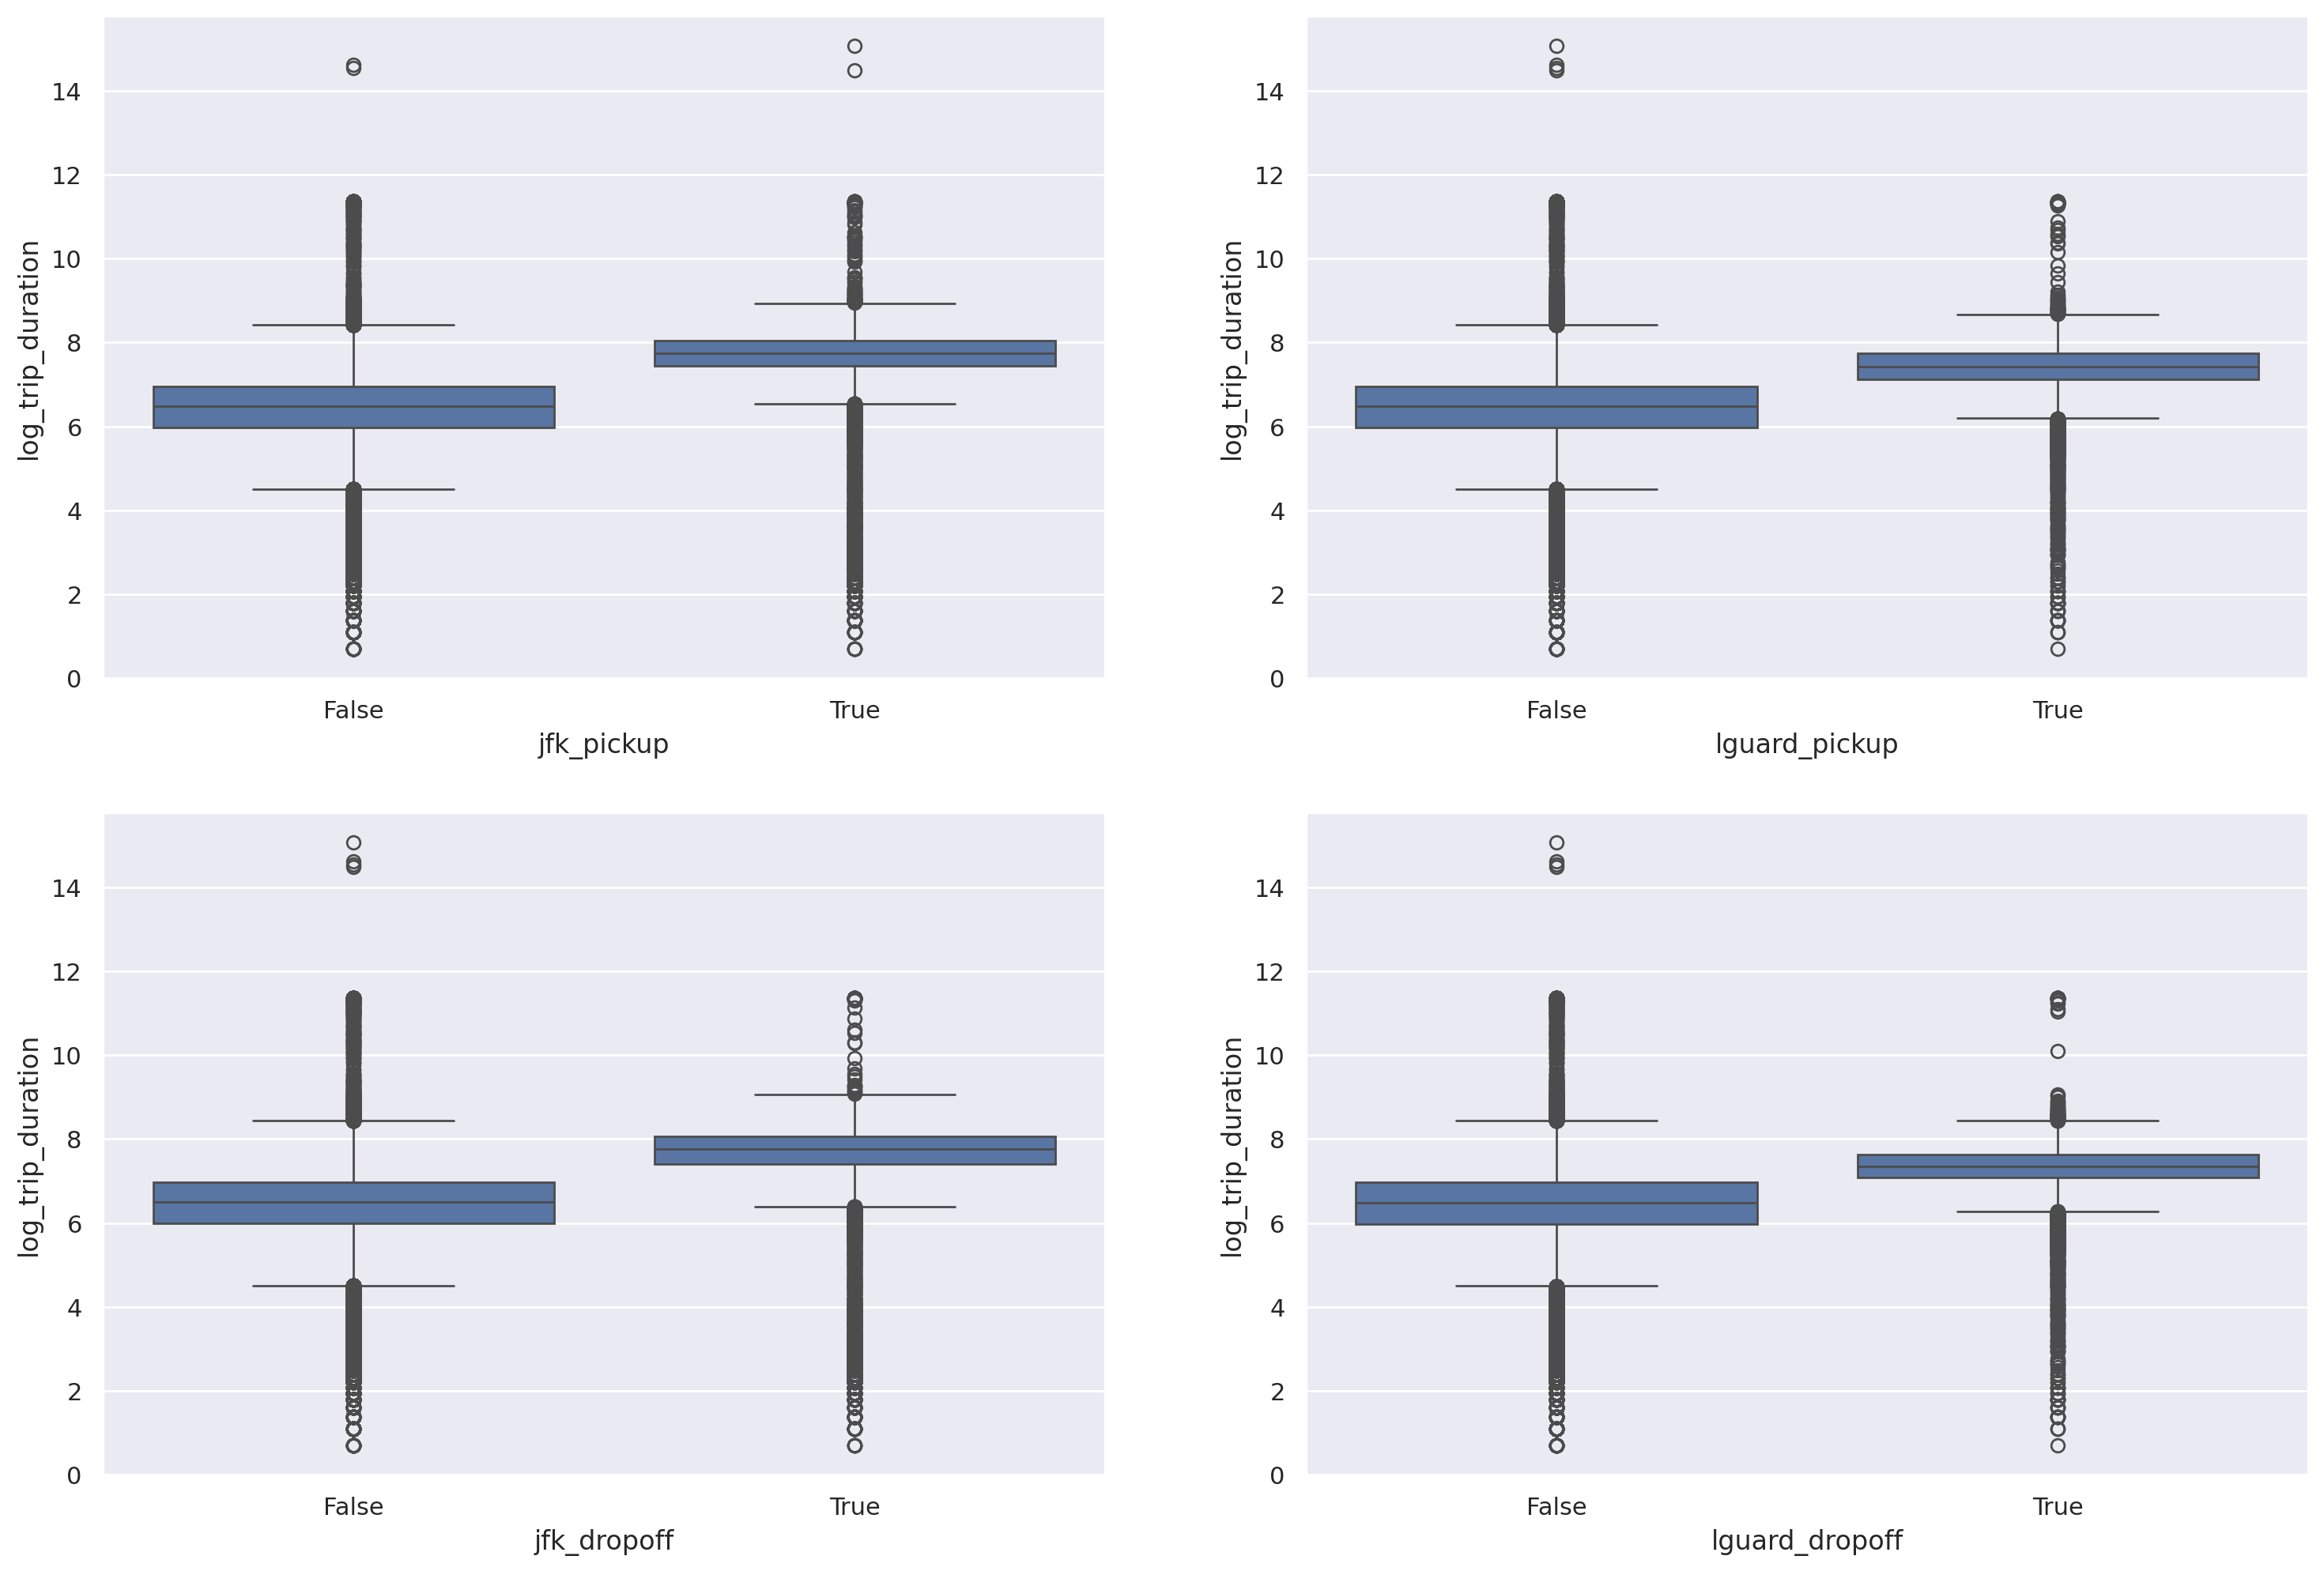

18967

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.boxplot( data = df, y = 'log_trip_duration', x = 'jfk_pickup', ax = axes[0,0])
sns.boxplot( data = df, y = 'log_trip_duration', x = 'jfk_dropoff', ax = axes[1,0])
sns.boxplot( data = df, y = 'log_trip_duration', x = 'lguard_pickup', ax = axes[0,1])
sns.boxplot( data = df, y = 'log_trip_duration', x = 'lguard_dropoff', ax = axes[1,1])

plt.show()
gc.collect()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Да, как раз имеется константный сдвиг доверительных интервалов выборки. Следовательно эти признаки хорошо будут отражать сдвиг целевой переменной.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.location = (40.744279696711416, -73.99015124487597)
        self.leftbottom = (40.70510832626442, -74.01903999138415)
        self.rightup = (40.801724559491575, -73.93681833732855)
        self.hgrid = 40
        self.vgrid = 30



    def show_map(self):
        m = folium.Map(location=self.location)
        lat_points = []
        long_points = []
        dx = (self.rightup[0] - self.leftbottom[0])/self.hgrid
        dy = (self.rightup[1] - self.leftbottom[1])/self.vgrid
        for i in range(self.hgrid):
          for j in range(self.vgrid):
            lat_points.append(self.leftbottom[0] + dx*i)
            long_points.append(self.leftbottom[1] + dy*j)
        for lat, lon in zip(lat_points, long_points):
          folium.Circle(
            radius=200,
            location=(lat, lon),
            color='red',
            fill_color='red',
            fill=True
          ).add_to(m)
          folium.Rectangle(
            bounds=[[lat - dx/2, lon - dy/2], [lat + dx/2, lon + dy/2]],
            line_join="round",
            dash_array="5, 5",
            color='red',
            fill=False
          ).add_to(m)

        return m

    def fit(self, X=None, y=None):
        pass


    def transform(self, X, y=None):
        X_copy = X.copy()


        h = self.rightup[0] - self.leftbottom[0]
        v = self.rightup[1] - self.leftbottom[1]
        X_copy['pickup_place'] = -1
        X_copy['dropoff_place'] = -1
        mask = ((self.leftbottom[0] <= X_copy['pickup_latitude']) & (self.leftbottom[1] <= X_copy['pickup_longitude']) & \
                   (X_copy['pickup_latitude'] <= self.rightup[0]) & (X_copy['pickup_longitude'] <=  self.rightup[1]))
        X_copy.loc[mask, 'pickup_place'] = np.floor(self.hgrid*(X_copy[mask]['pickup_latitude'] - self.leftbottom[0])/h) + self.hgrid*np.floor(self.vgrid*(X_copy[mask]['pickup_longitude'] - self.leftbottom[1])/v)

        mask = ((self.leftbottom[0] <= X_copy['dropoff_latitude']) & (self.leftbottom[1] <= X_copy['dropoff_longitude']) & \
                   (X_copy['dropoff_latitude'] <= self.rightup[0]) & (X_copy['dropoff_longitude'] <=  self.rightup[1]))
        X_copy.loc[mask, 'dropoff_place'] = np.floor(self.hgrid*(X_copy[mask]['dropoff_latitude'] - self.leftbottom[0])/h) + self.hgrid*np.floor(self.vgrid*(X_copy[mask]['dropoff_longitude'] - self.leftbottom[1])/v)
        X_copy = X_copy.drop(columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

        X_copy['pickup_place'] = X_copy['pickup_place'].astype('object')
        X_copy['dropoff_place'] = X_copy['dropoff_place'].astype('object')
        return X_copy


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [33]:
grid_beater = MapGridTransformer()
X =  grid_beater.transform(df.loc[:,'pickup_longitude':].drop(columns = ['store_and_fwd_flag', 'log_trip_duration']))
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)




numeric = list(X_train.select_dtypes(include=np.number).columns)
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("Train RMSLE = %.4f" % root_mean_squared_error(y_train, y_train_pred))
print("Test RMSLE = %.4f" % root_mean_squared_error(y_test, y_pred))


gc.collect()

Train RMSLE = 0.4683
Test RMSLE = 0.4661


94

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

`vendor_id` - номер провайдера. От конкретного провайдера может зависить: модель машины, проезд по платным трассам, покрытие территории и как следствие скорость, соотвественно и время поездки.

`passenger_count` - два аргумента. Незначительно на скорость влияет вес машины, но что более важно, часть пассажиров могли высаживаться по дороге, что замедляет совокупный путь.

 `store_and_fwd_flag` - это может влиять на лаг времени на передачу данных, на то что таксист потенциально мог подкручивать счетчик, на баги аппаратуры.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [34]:
from IPython.display import display
display(df.groupby('vendor_id').count()['id'])
display(df.groupby('passenger_count').count()['id'])
display(df.groupby('store_and_fwd_flag').count()['id'])

vendor_id
1    678342
2    780302
Name: id, dtype: int64

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: id, dtype: int64

store_and_fwd_flag
N    1450599
Y       8045
Name: id, dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

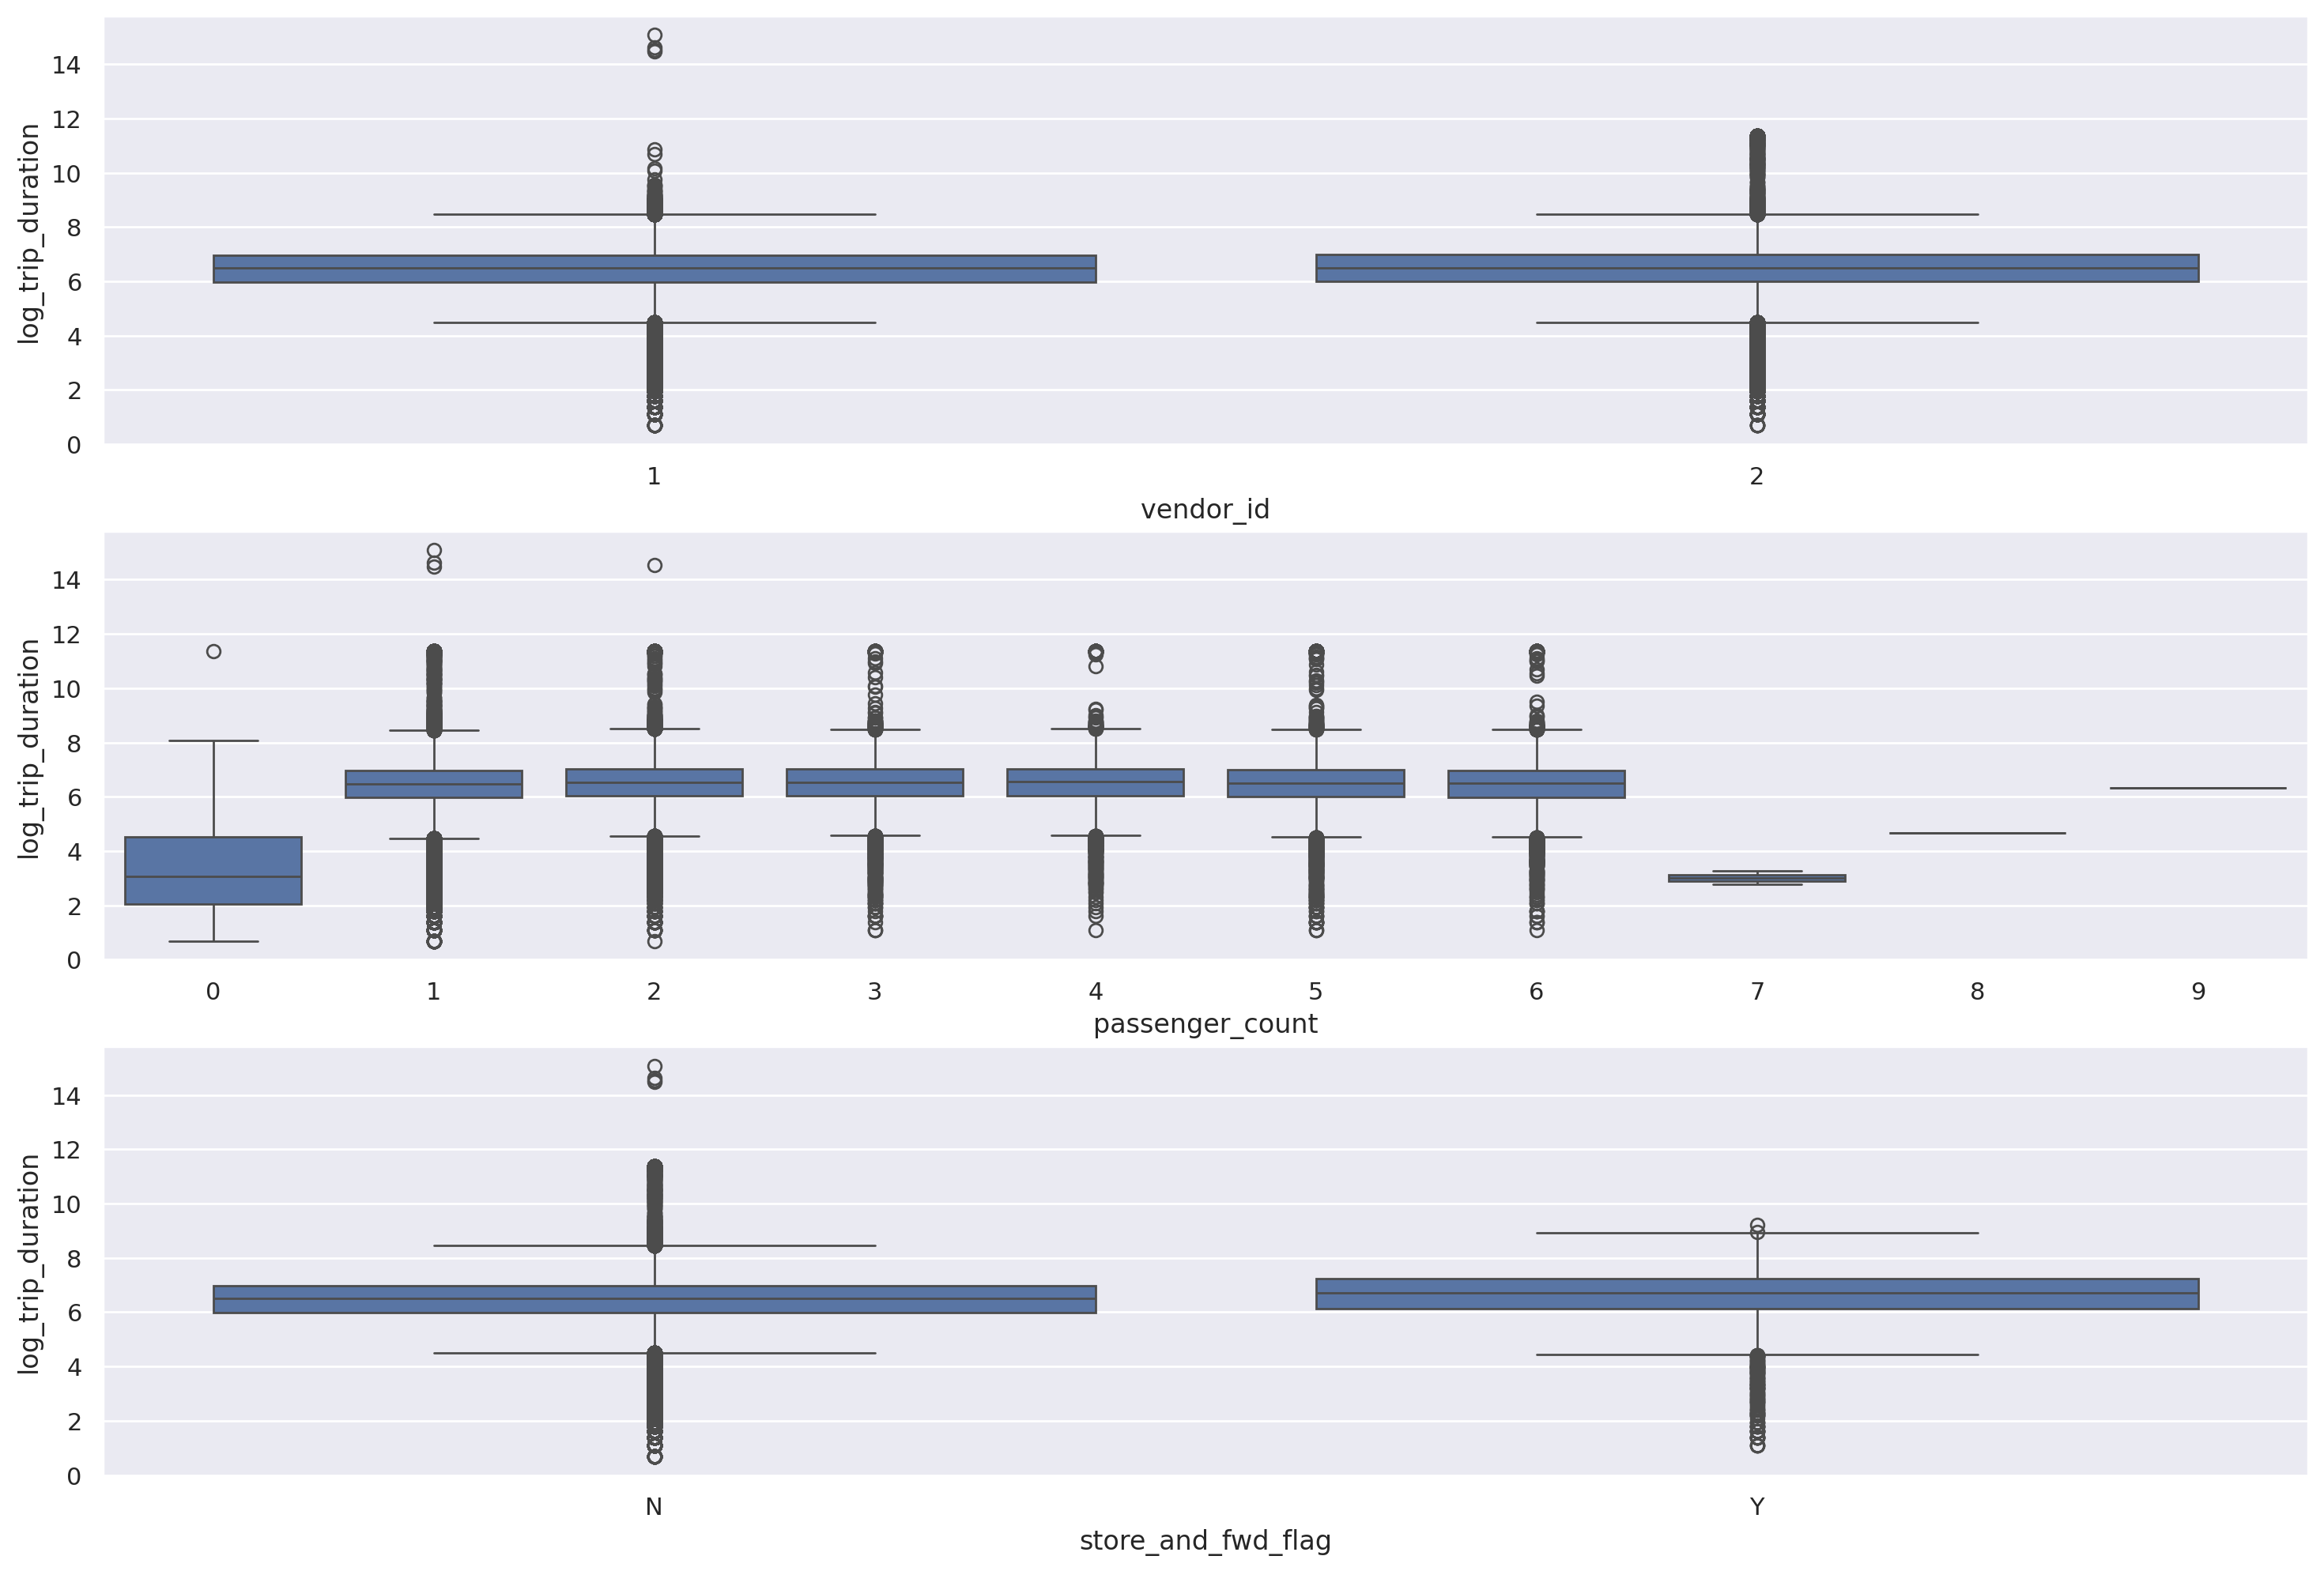

15182

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(18, 12))
sns.boxplot( data = df, y = 'log_trip_duration', x = 'vendor_id', ax = axes[0])
sns.boxplot( data = df, y = 'log_trip_duration', x = 'passenger_count', ax = axes[1])
sns.boxplot( data = df, y = 'log_trip_duration', x = 'store_and_fwd_flag', ax = axes[2])

plt.show()
gc.collect()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [36]:
df = df.replace({'vendor_id': {1 : 0, 2 : 1}})
df = df.replace({'store_and_fwd_flag': {'N' : 0, 'Y' : 1}})
df['vendor_id'] = df['vendor_id'].astype('bool')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('bool')
df['passenger_count'] = df['passenger_count'].astype('object')
df.dtypes

<ipython-input-36-1f082db159a5>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'store_and_fwd_flag': {'N' : 0, 'Y' : 1}})


id                            object
vendor_id                       bool
pickup_datetime       datetime64[ns]
passenger_count               object
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag              bool
log_trip_duration            float64
weekday                       object
month                         object
hour                          object
day                            int32
blizzard                        bool
memorial_day                    bool
haversine                    float64
log_haversine                float64
traffic_jams                    bool
traffic_free                    bool
jfk_pickup                      bool
jfk_dropoff                     bool
lguard_pickup                   bool
lguard_dropoff                  bool
dtype: object

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

`vendor_id` - не особо, имеется легкий сдвиг + меньшая дисперсия.

`passenger_count` - существенно влияет поездка без пассажира или с аномальным количеством пассажиров. Остальное слабо.

 `store_and_fwd_flag` - аналагично айди, легкий сдвиг + меньшая дисперсия.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [37]:
grid_beater = MapGridTransformer()
X =  grid_beater.transform(df.loc[:,'vendor_id':].drop(columns = ['log_trip_duration']))
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)




numeric = list(X_train.select_dtypes(include=np.number).columns)
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("Train RMSLE = %.4f" % root_mean_squared_error(y_train, y_train_pred))
print("Test RMSLE = %.4f" % root_mean_squared_error(y_test, y_pred))


gc.collect()
df = df.drop(columns = ['vendor_id', 'passenger_count', 'store_and_fwd_flag'])

Train RMSLE = 0.4679
Test RMSLE = 0.4660


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [38]:
grid_beater = MapGridTransformer()
X =  grid_beater.transform(df.loc[:,'pickup_datetime':].drop(columns = ['log_trip_duration']))
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)




numeric = list(X_train.select_dtypes(include=np.number).columns)
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("Train RMSLE = %.4f" % root_mean_squared_error(y_train, y_train_pred))
print("Test RMSLE = %.4f" % root_mean_squared_error(y_test, y_pred))


gc.collect()
df.dtypes

Train RMSLE = 0.4683
Test RMSLE = 0.4661


id                           object
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
log_trip_duration           float64
weekday                      object
month                        object
hour                         object
day                           int32
blizzard                       bool
memorial_day                   bool
haversine                   float64
log_haversine               float64
traffic_jams                   bool
traffic_free                   bool
jfk_pickup                     bool
jfk_dropoff                    bool
lguard_pickup                  bool
lguard_dropoff                 bool
dtype: object

<ipython-input-39-3c821074d22d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['log_trip_duration'], ax = axes[0,0])
<ipython-input-39-3c821074d22d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['log_haversine'], ax = axes[1,0])
<ipython-input-39-3c821074d22d>:5: UserWarning: 

`distp

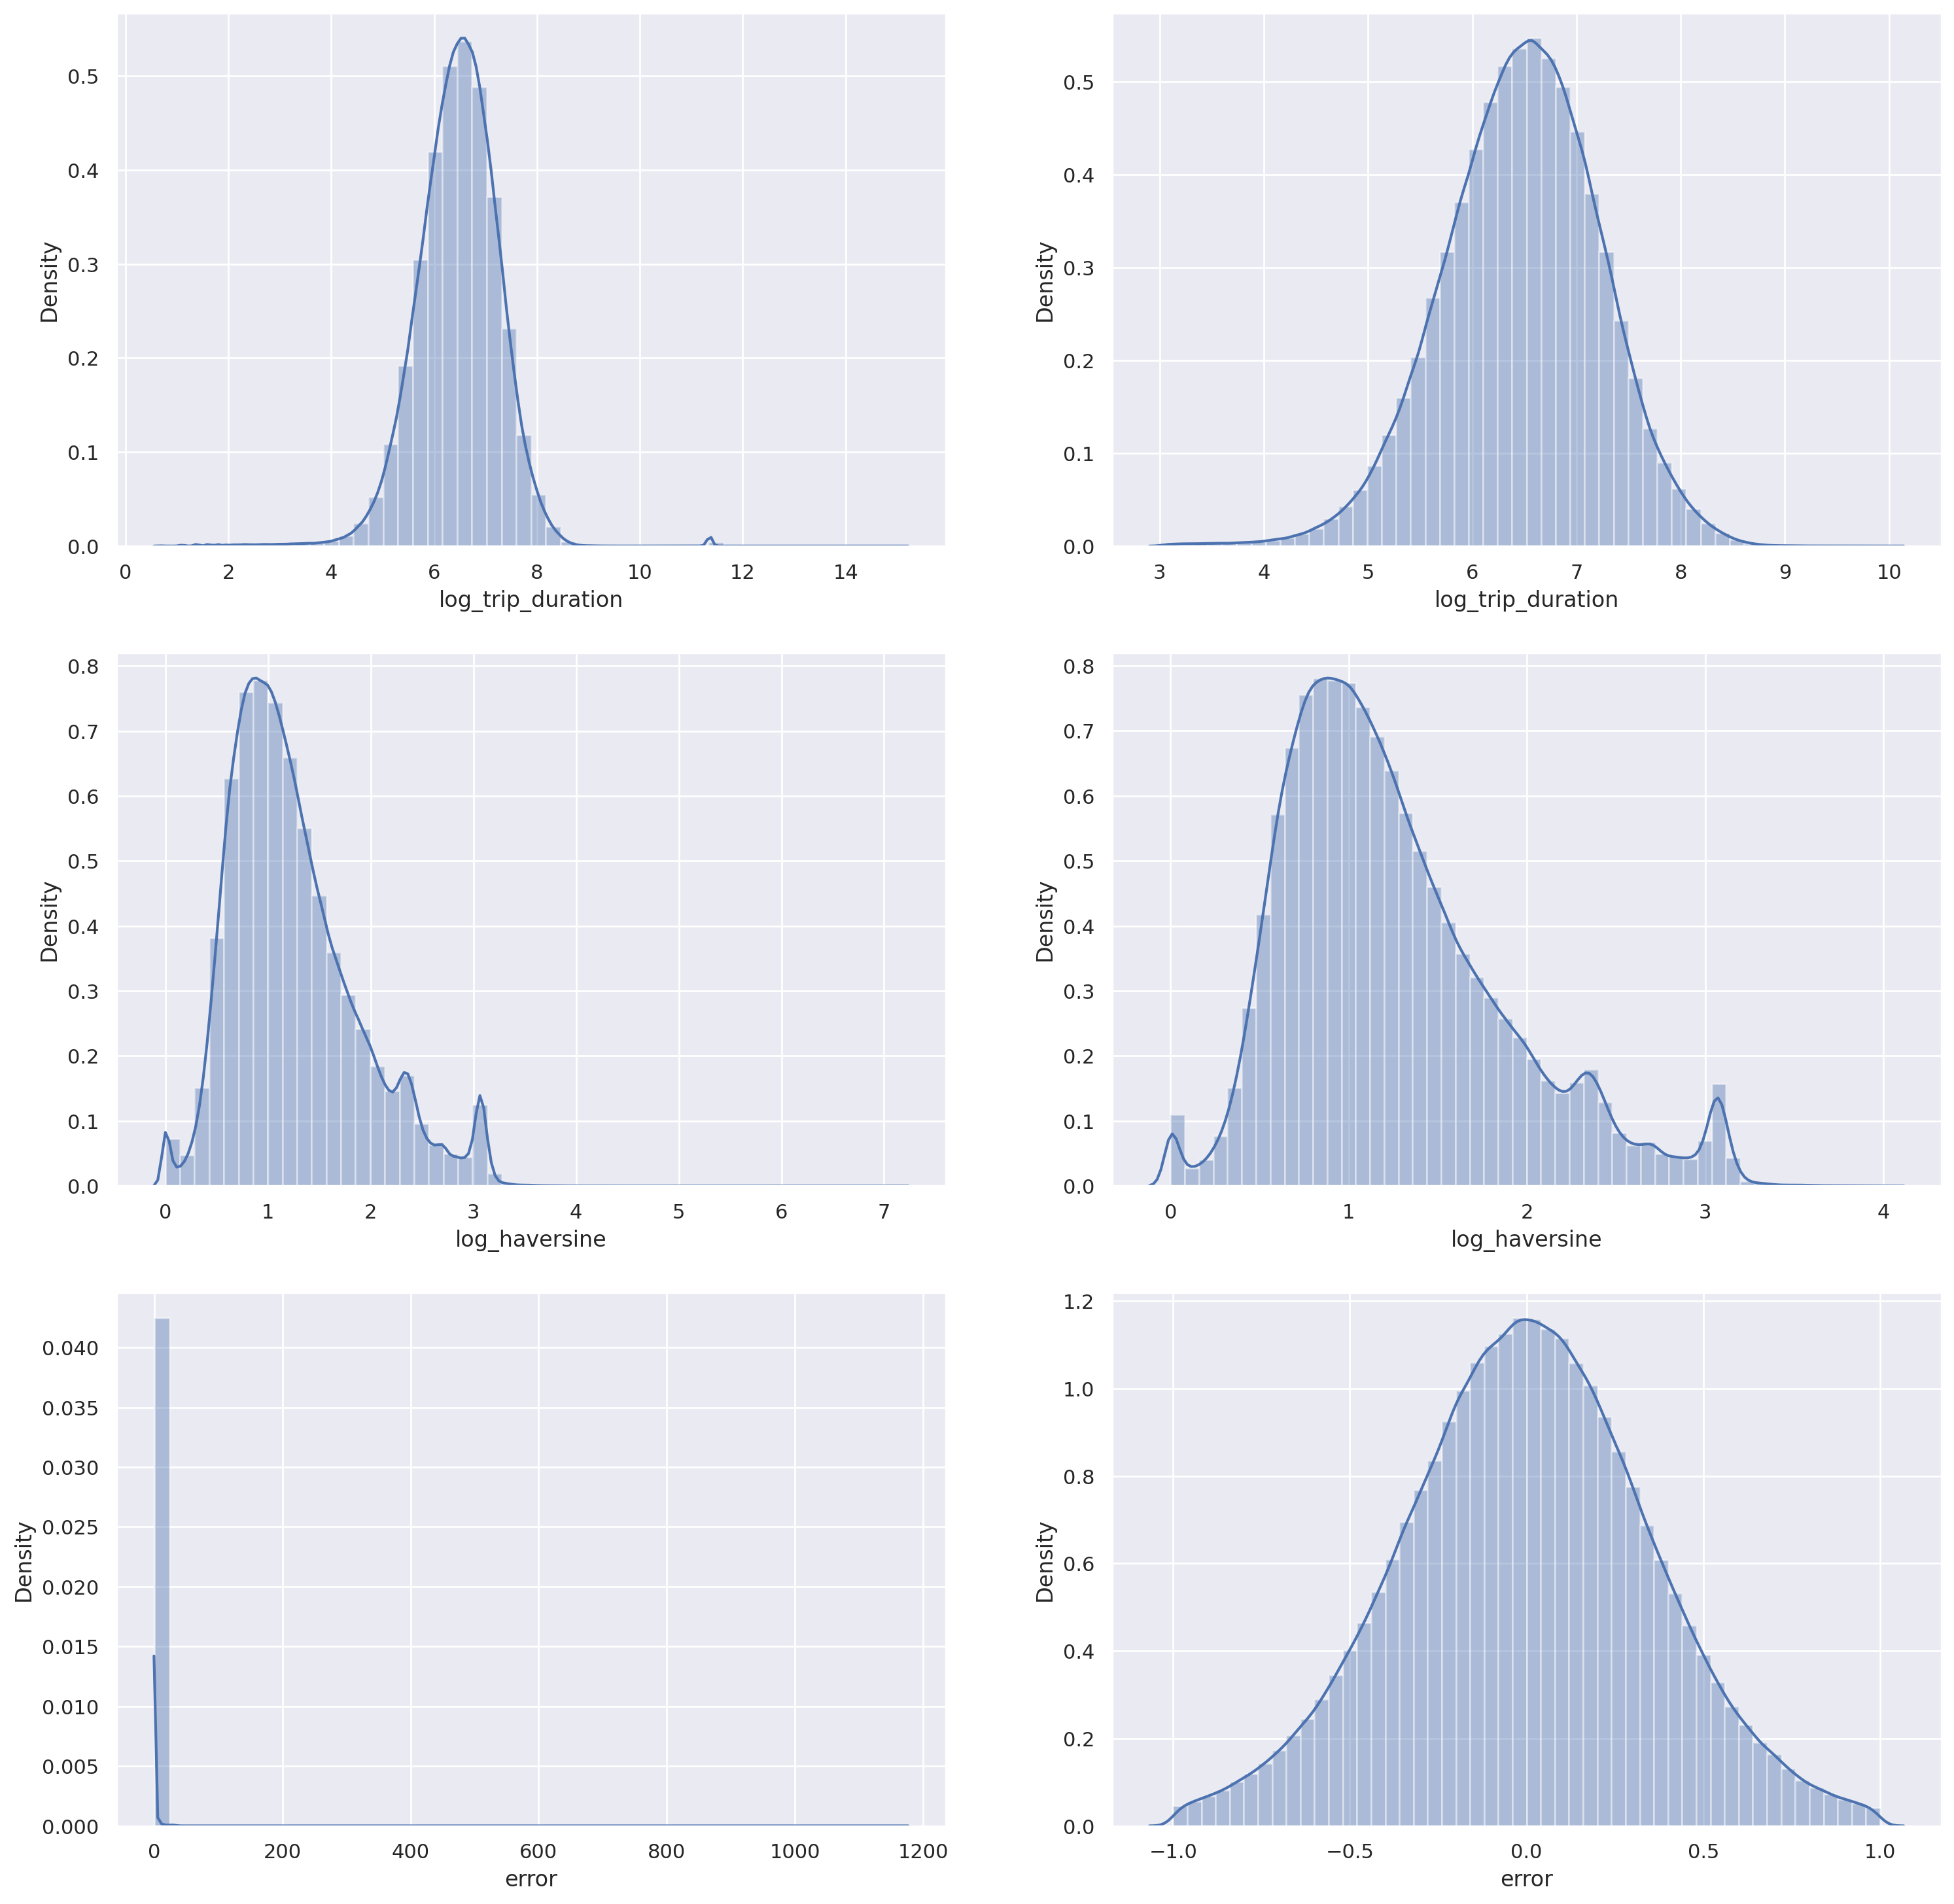

15933

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
sns.distplot(df['log_trip_duration'], ax = axes[0,0])
sns.distplot(df['log_haversine'], ax = axes[1,0])
error = (y_train - y_train_pred) ** 2
sns.distplot(error, ax = axes[2,0])

sns.distplot(y_train[(y_train > 3) & (y_train < 10)], ax = axes[0,1])
sns.distplot(X_train[X_train['log_haversine'] < 4]['log_haversine'], ax = axes[1,1])
error = (y_train - y_train_pred)
sns.distplot(error[(-1 < error) & (error < 1)], ax = axes[2,1])

axes[2,0].set_xlabel("error")
axes[2,1].set_xlabel("error")

plt.show()
gc.collect()

<ipython-input-40-8e7afb195fe5>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[((-1 < error) & (error < 1))]
<ipython-input-40-8e7afb195fe5>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, ax = axes[0])
<ipython-input-40-8e7afb195fe5>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwask

Text(0.5, 0, 'error')

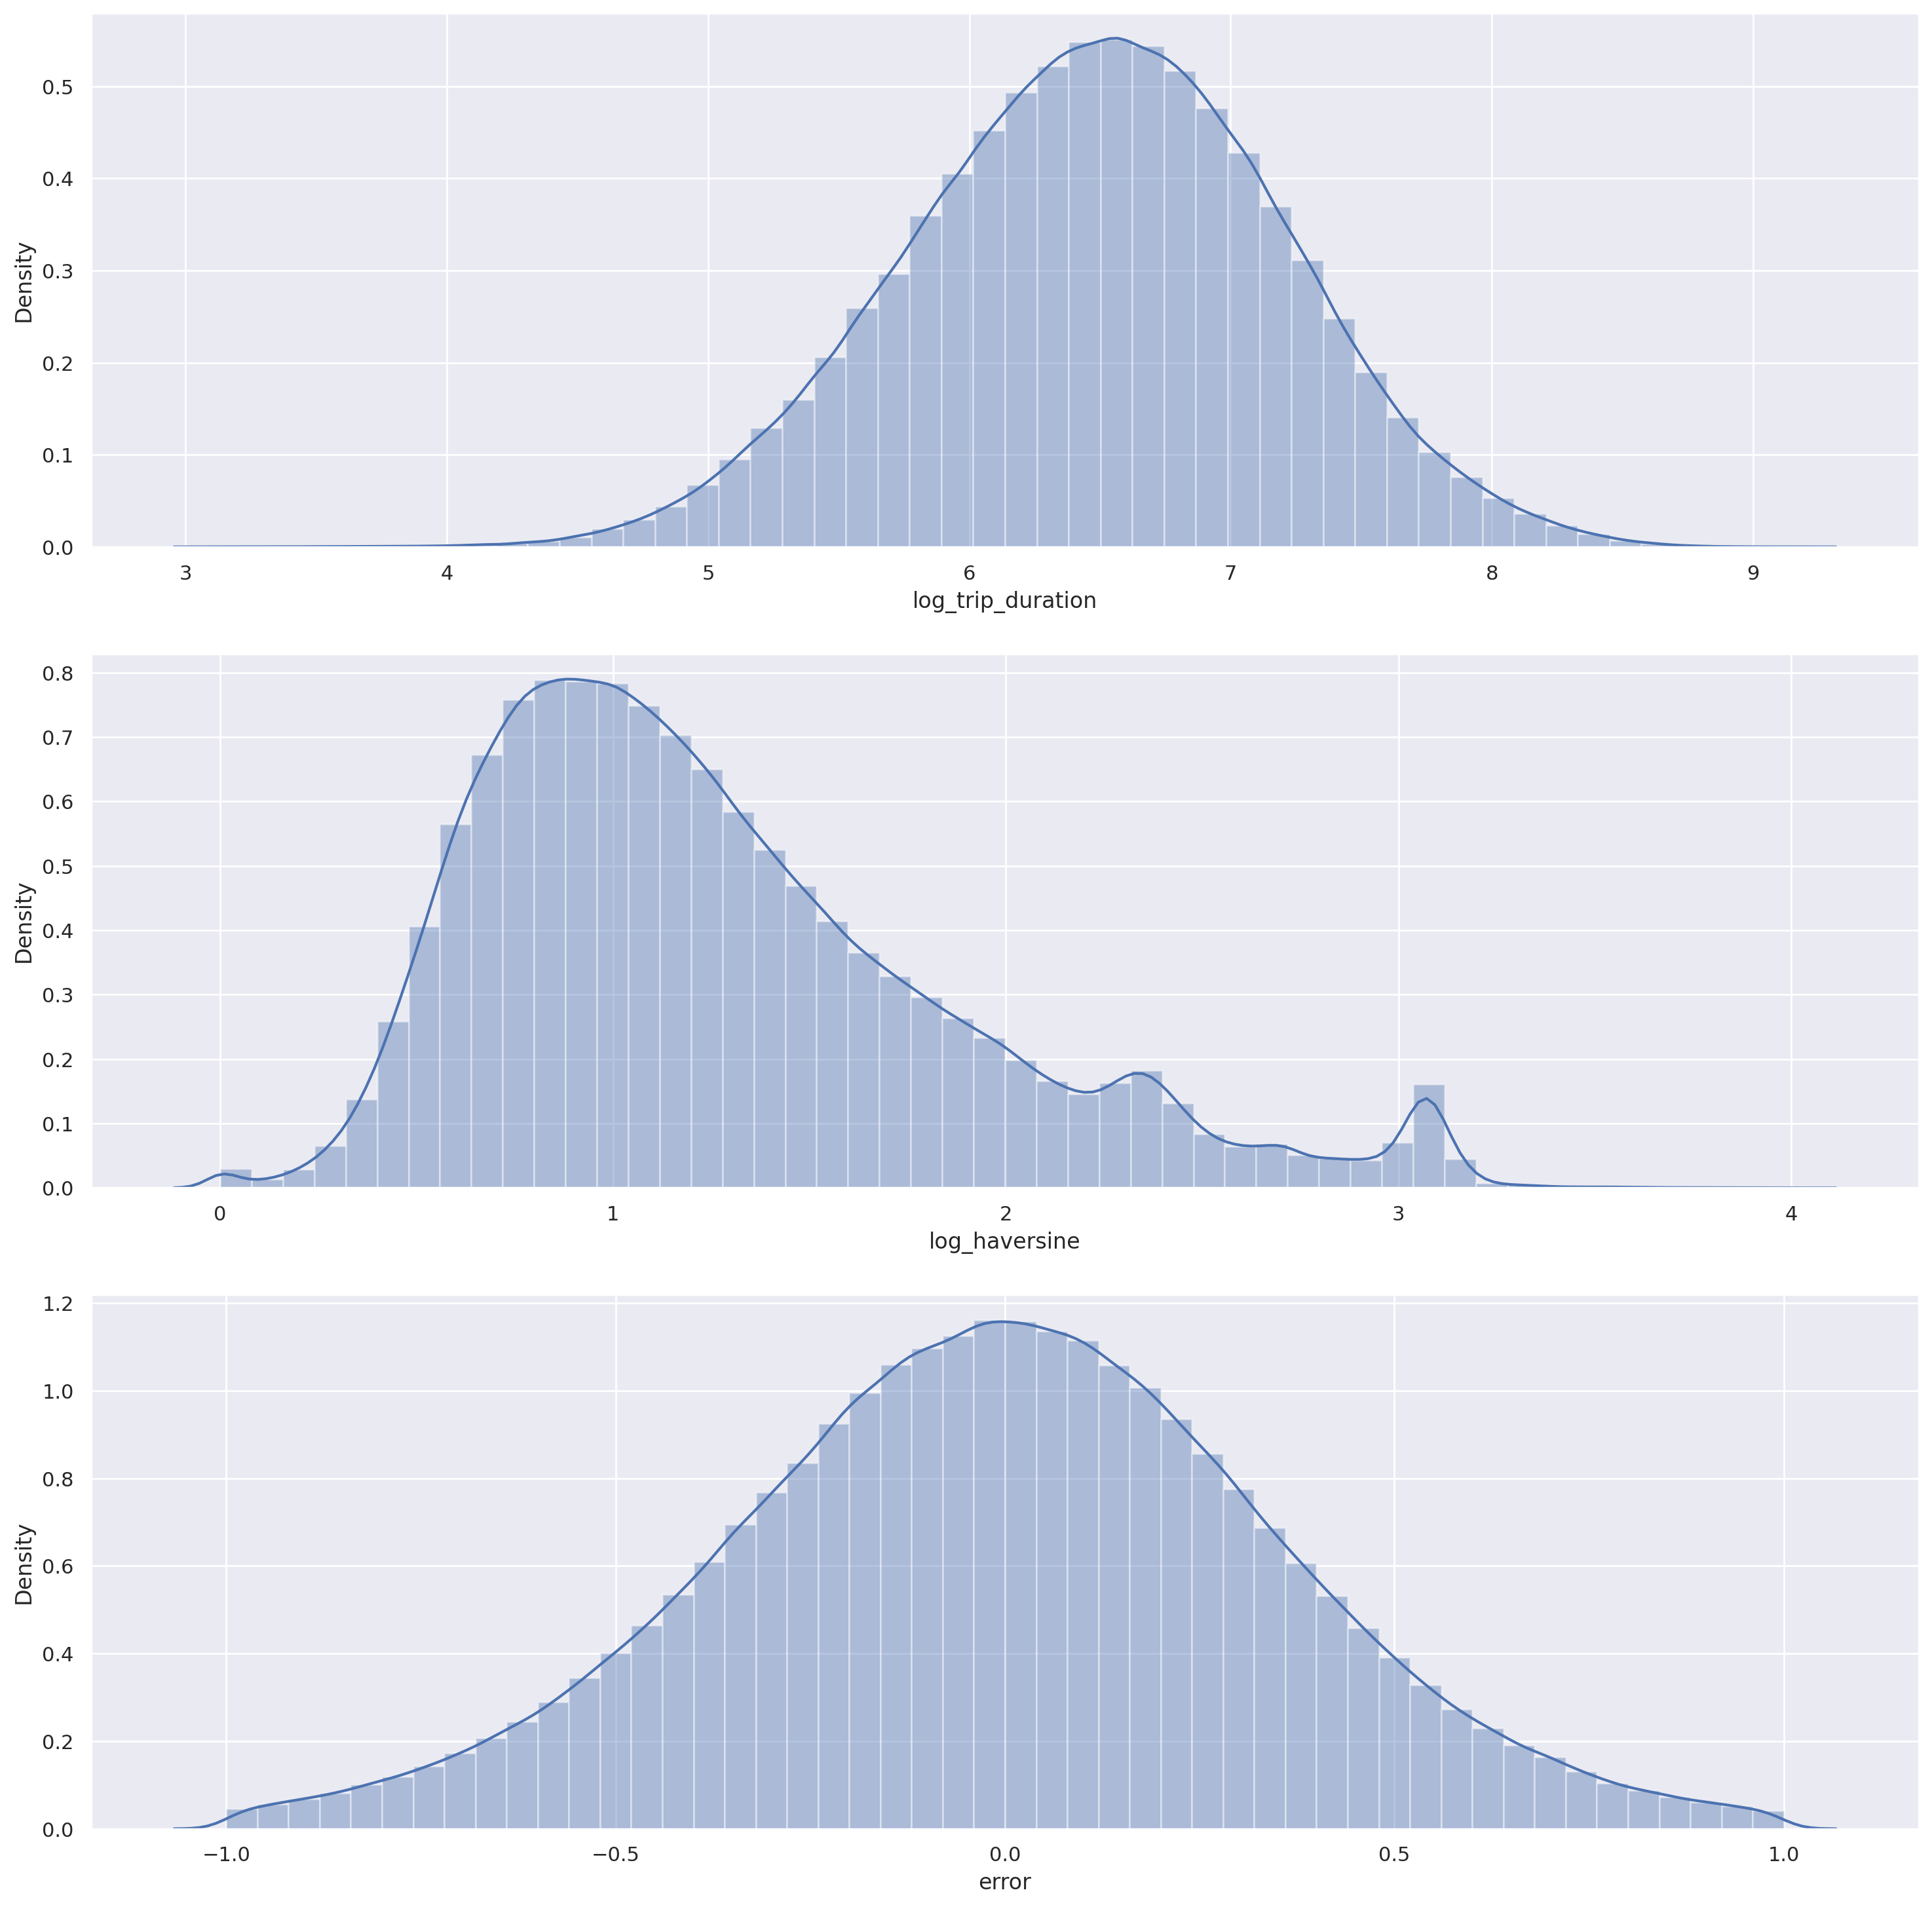

In [40]:
X_train = X_train[((y_train > 3) & (y_train < 10))]
y_train = y_train[((y_train > 3) & (y_train < 10))]
X_train = X_train[X_train['log_haversine'] < 4]
y_train = y_train[(X_train['log_haversine'] < 4).index]
X_train = X_train[((-1 < error) & (error < 1))]
y_train = y_train[((-1 < error) & (error < 1))]
y_train_pred = model.predict(X_train)

fig, axes = plt.subplots(3, 1, figsize=(18, 18))
sns.distplot(y_train, ax = axes[0])
sns.distplot(X_train['log_haversine'], ax = axes[1])
error = (y_train - y_train_pred)
sns.distplot(error, ax = axes[2])
axes[2].set_xlabel("error")




Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

Дни недели, часы, месяцы - не особо редкие категории. У бинарных категорий и объединять нечего. Остаются 2 признака - посадка, высадка с мест на Манхэттене.

(0.0, 40000.0)

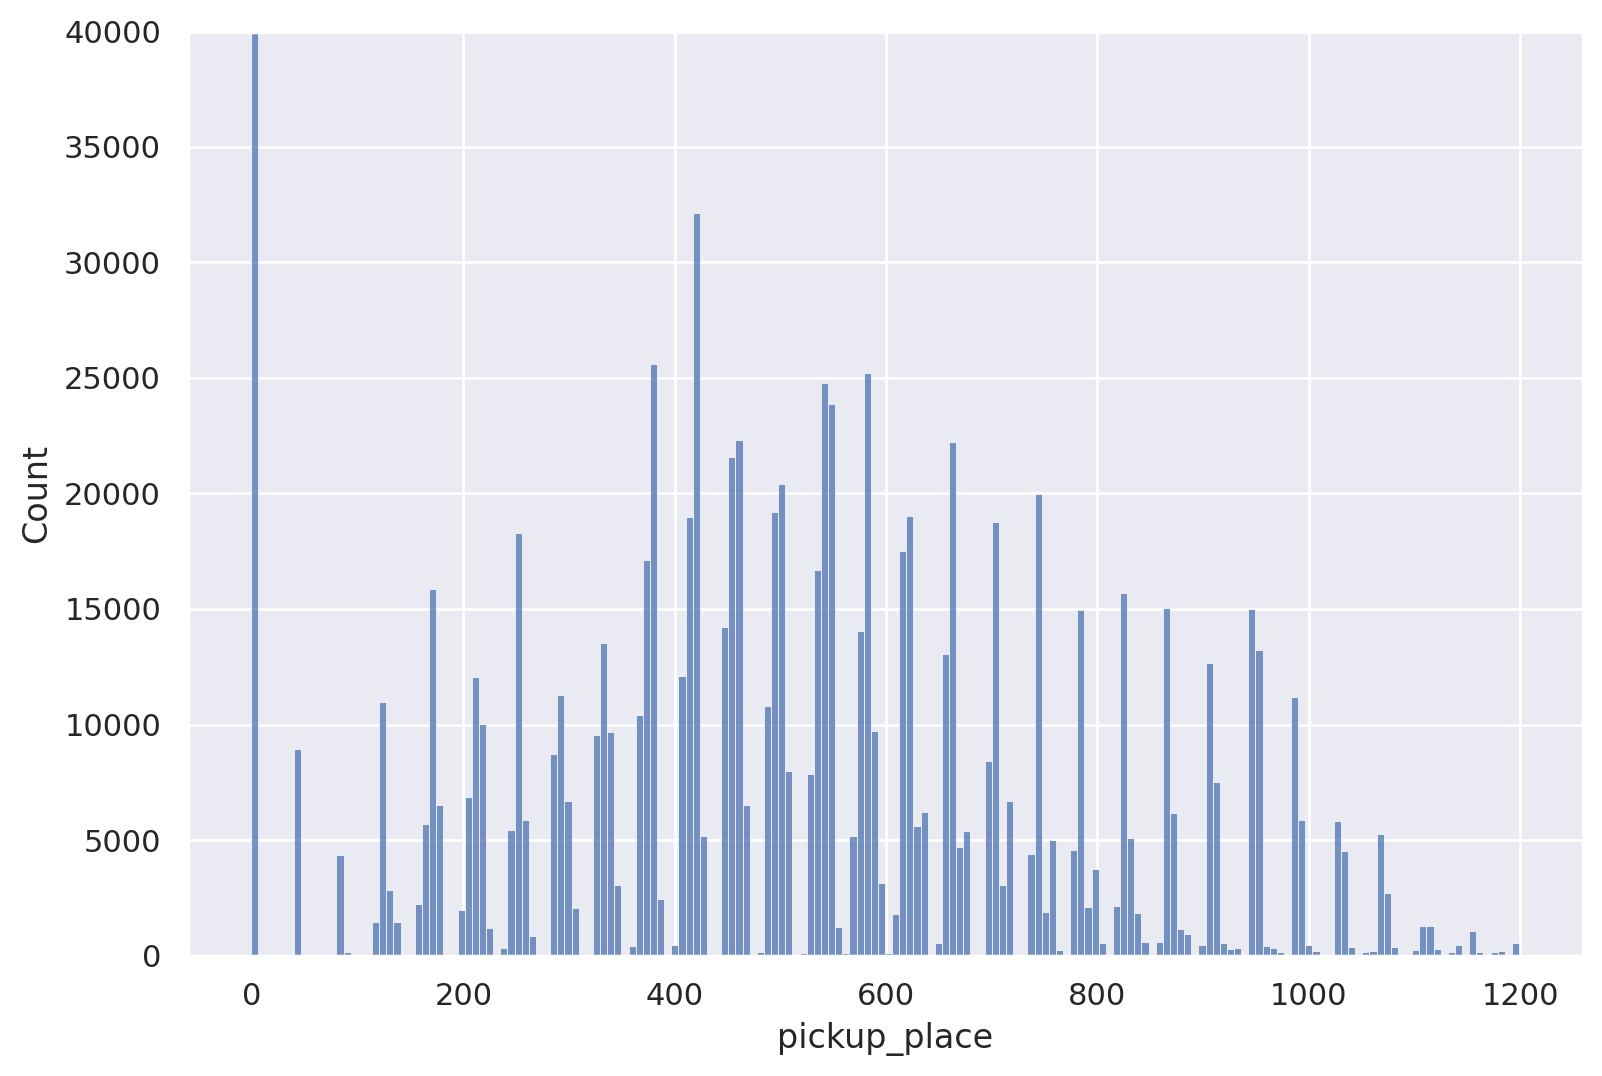

In [41]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(data=X_train, x="pickup_place", ax=ax)
ax.set_ylim(0,40000)

(0.0, 40000.0)

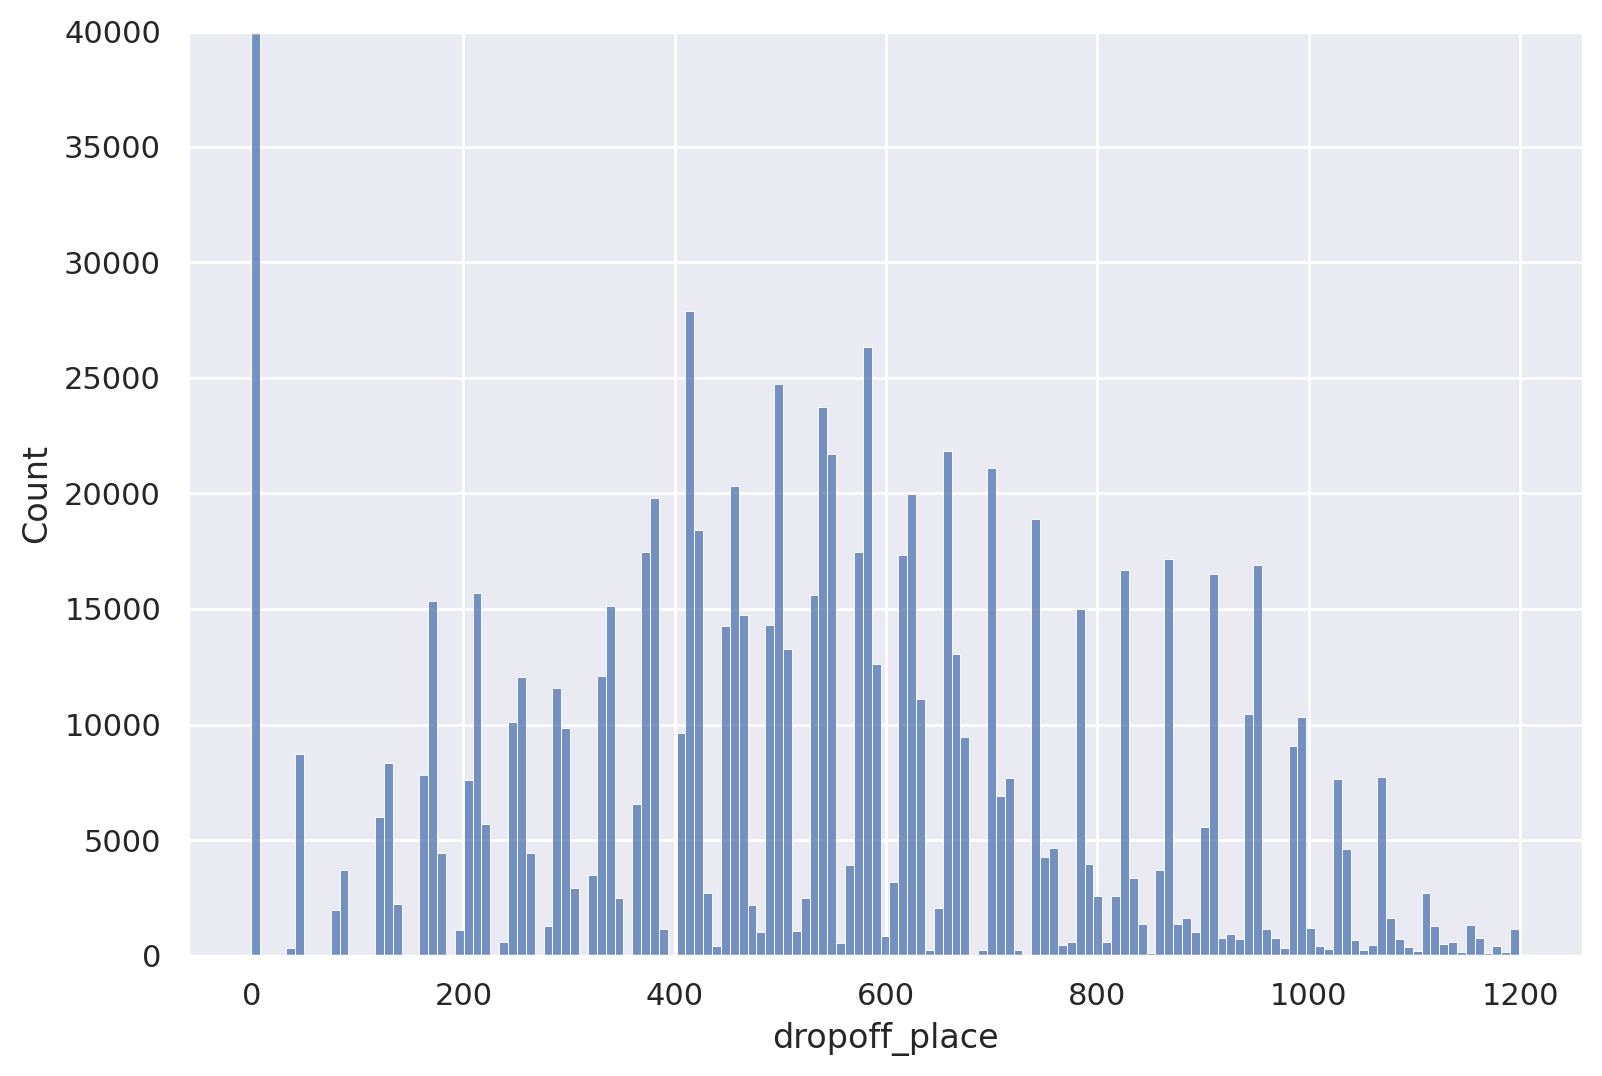

In [42]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(data=X_train, x="dropoff_place", ax=ax)
ax.set_ylim(0,40000)

Объеденим категории с меньше, чем 1000 поездок.

In [43]:
X_train.loc[X_train['pickup_place'].isin(X_train.groupby('pickup_place').count()[X_train.groupby('pickup_place')['day'].count() < 1000].index), 'pickup_place'] = 0
X_train.loc[X_train['dropoff_place'].isin(X_train.groupby('dropoff_place').count()[X_train.groupby('dropoff_place')['day'].count() < 1000].index), 'dropoff_place'] = 0

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [44]:
numeric = list(X_train.select_dtypes(include=np.number).columns)
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("Train RMSLE = %.4f" % root_mean_squared_error(y_train, y_train_pred))
print("Test RMSLE = %.4f" % root_mean_squared_error(y_test, y_pred))


gc.collect()

Train RMSLE = 0.3535
Test RMSLE = 0.4703


37766

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [45]:
X_copy = X_train.copy()
X_copy = column_transformer.fit_transform(X_copy)
print("Количество до OHE:", X_train.shape[1])
print("Количество после OHE:", X_copy.shape[1])

Количество до OHE: 17
Количество после OHE: 712


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [46]:
from sklearn.linear_model import Lasso

pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])


model_lasso = pipeline_lasso.fit(X_train, y_train)
y_pred = model_lasso.predict(X_test)
y_train_pred = model_lasso.predict(X_train)
print("Train RMSLE = %.4f" % root_mean_squared_error(y_train, y_train_pred))
print("Test RMSLE = %.4f" % root_mean_squared_error(y_test, y_pred))


gc.collect()

Train RMSLE = 0.7139
Test RMSLE = 0.7945


14014

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [47]:
alphas = np.logspace(-3, 3, 20)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.2, random_state=10)
rid_a = {}
las_a = {}
zeros = {}
for a in alphas:
  pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(a))
  ])
  model = pipeline.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  rid_a[a] = root_mean_squared_error(y_val, y_pred)

  pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(a))
  ])
  model_lasso = pipeline_lasso.fit(X_train, y_train)
  y_pred = model_lasso.predict(X_val)
  las_a[a] = root_mean_squared_error(y_val, y_pred)
  zeros[a] = np.sum(pipeline_lasso.steps[-1][-1].coef_ == 0)

best_alpha_ridge = min(rid_a, key=rid_a.get)
best_alpha_lasso = min(las_a, key=las_a.get)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSLE Ridge:", root_mean_squared_error(y_test, y_pred))

pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])
model_lasso = pipeline_lasso.fit(X_train, y_train)
y_pred = model_lasso.predict(X_test)
print("RMSLE Lasso:", root_mean_squared_error(y_test, y_pred))

RMSLE Ridge: 0.4702915302144365
RMSLE Lasso: 0.48643973788164974


Сохраните наилучшее значение, как бенчмарк на будущее

In [48]:
best_rmsle = 0.470307147877839

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

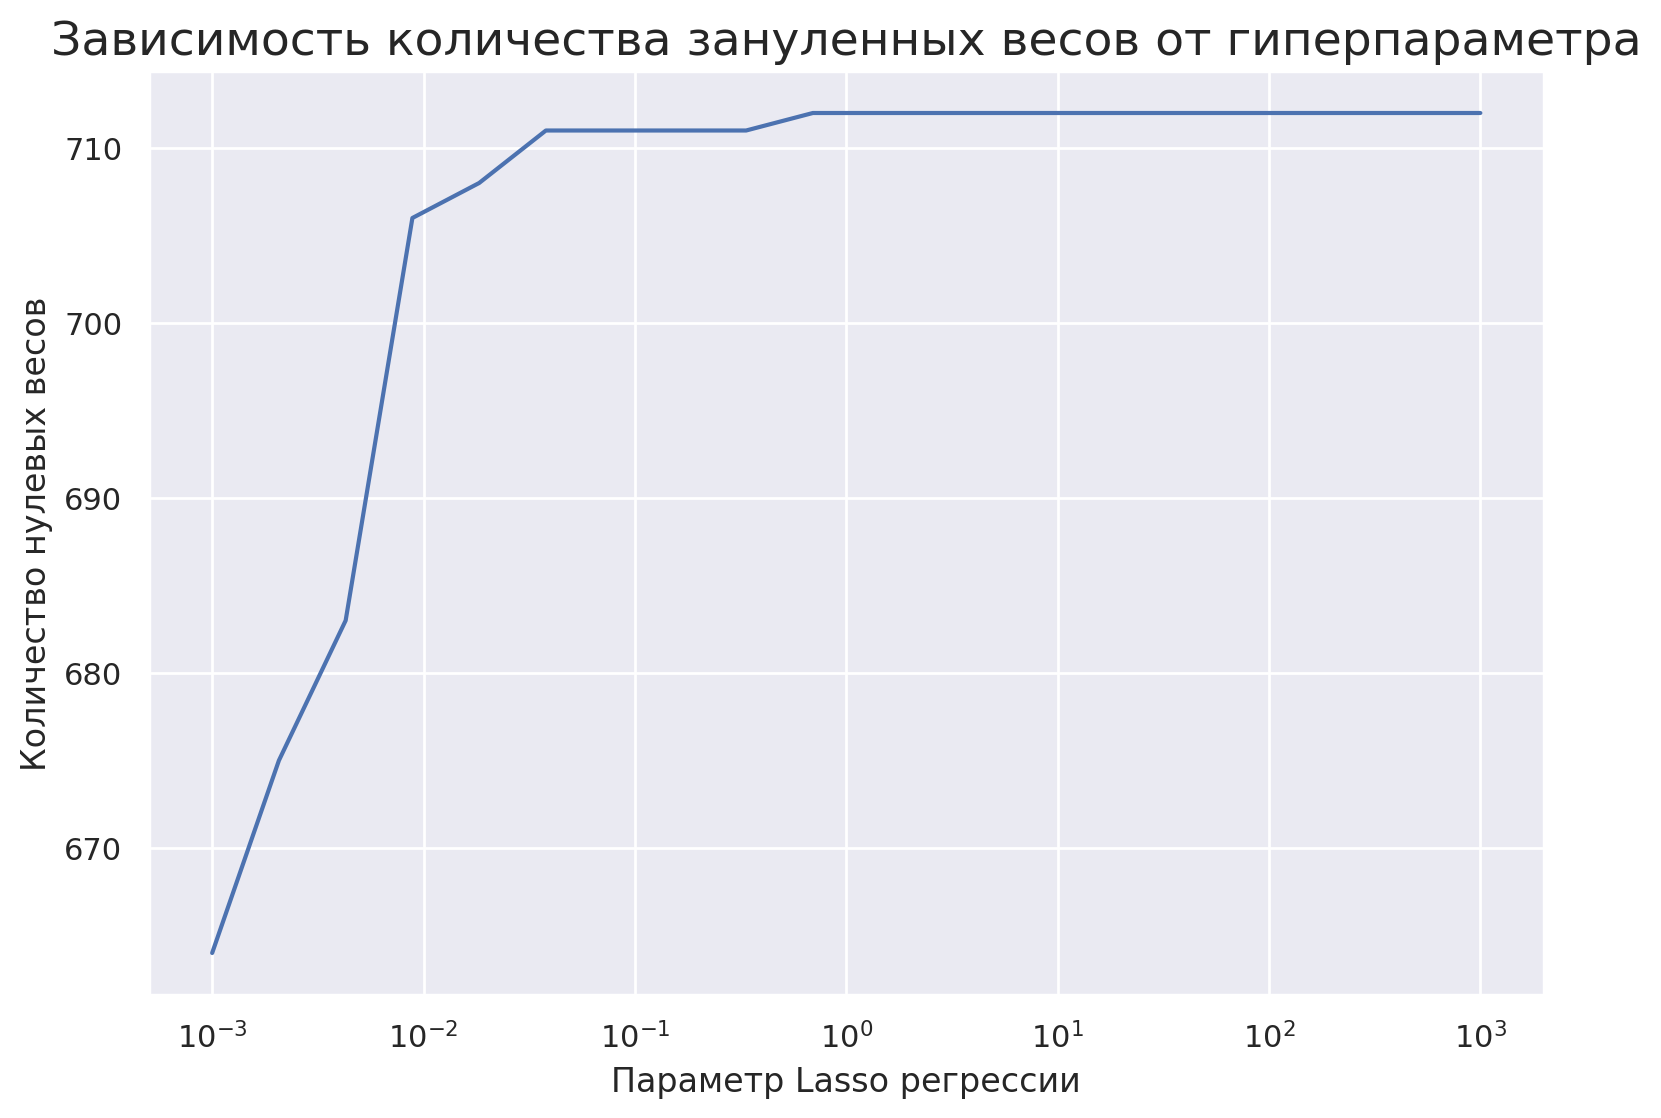

In [49]:
fig = plt.figure(figsize = (9, 6))

lists = sorted(zeros.items())

x, y = zip(*lists)

plt.plot(x,y)


plt.title('Зависимость количества зануленных весов от гиперпараметра', fontsize = 17)
plt.xlabel('Параметр Lasso регрессии')
plt.ylabel('Количество нулевых весов')
plt.xscale('log')




plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

Этот признак может дать информацию о том, насколько популярен и востребован похожий маршрут. Это может хранить в себе информацию о пробках, качестве дороги, частично инфраструктуры города. Просто напросто ячейки дают мало информации о топологии города. Они говорят о популярности конкретных мест. Приведем пример, когда это может помочь: пусть среди всех у нас есть две особо популярные точки. Между ними открыли скоростную трассу. Так же предположим, что доля маршрутов между этими двумя точками значительна, но не подавляющая. Тогда при открытии трассы, сильно веса при "координатах" не изменятся. Однако вес при маршруте между точками изменится существенно.

In [50]:
for i,j in X_train.groupby(['pickup_place', 'dropoff_place'])['day'].count().nlargest(100).index:
  name = 'from_' + str(i) + '_to_' + str(j)
  X_train[name] = False
  X_train.loc[((X_train['pickup_place'] == i)&(X_train['dropoff_place'] == j)), name] = True
  X_test[name] = False
  X_test.loc[((X_test['pickup_place'] == i)&(X_test['dropoff_place'] == j)), name] = True
X_train.columns


<ipython-input-50-c5dc792e9b8c>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[name] = False
<ipython-input-50-c5dc792e9b8c>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[name] = False
<ipython-input-50-c5dc792e9b8c>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[name] =

Index(['pickup_datetime', 'weekday', 'month', 'hour', 'day', 'blizzard',
       'memorial_day', 'haversine', 'log_haversine', 'traffic_jams',
       ...
       'from_377_to_0', 'from_550_to_-1', 'from_497_to_-1', 'from_211_to_0',
       'from_447_to_-1', 'from_328_to_-1', 'from_592_to_-1', 'from_658_to_-1',
       'from_-1_to_462', 'from_0_to_174'],
      dtype='object', length=117)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [51]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])


model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("Train RMSLE = %.4f" % root_mean_squared_error(y_train, y_train_pred))
print("Test RMSLE = %.4f" % root_mean_squared_error(y_test, y_pred))


gc.collect()

Train RMSLE = 0.3535
Test RMSLE = 0.4703


81

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [52]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [53]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

In [54]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

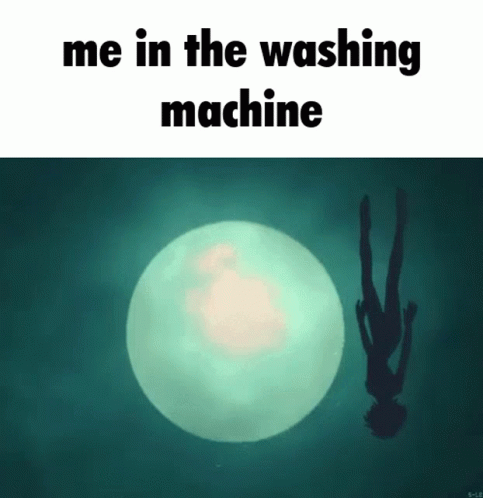